<h1 align="center"> <b> Customer loyalty program for E-commerce </b> </h1>

## <b> Outleto and Business Problem </b>

<p align="justify"> Outleto is a multibrand outlet company, meaning it sells second line products of various companies at lower prices, through an E-commerce platform. Outleto's Marketing Team noticed that some customers tend to buy more expensive products, in higher quantities and more frequently than others, therefore contributing to a higher share of Outleto's total gross revenue. Because of that, Outleto's Marketing Team wishes to launch a customer loyalty program, dividing the 5,702 customers in clusters, on which the best customers will be placed in a cluster named Insiders. </p>

<p align="justify"> To achieve this goal, the Data Science Team was requested to provide a business report regarding the clusters, containing a list of customers that will participate in Insiders, as well as answers to the following questions: </p>
  
1) **How many customers will be a part of Insiders?**
2) **How many clusters were created?**
3) **How are the customers distributed amongst the clusters?**
4) **What are these customers' main features?**
5) **What's the gross revenue percentage coming from Insiders? And what about other clusters?**
6) **How many items were purchased by each cluster?**

With that report the Marketing Team will promote actions to each cluster, in order to increase revenue, but of course focusing mostly in the Insiders cluster.

<i> Obs: The company and business problem are both fictitious, although the data is real. </i>

## 1. **Imports**

#### 1.1. **Libraries**

In [1]:
import re
import numpy  as np
import pandas as pd

import seaborn           as sns
import matplotlib.pyplot as plt
from matplotlib.axes._axes import Axes
from IPython.display     import Image

import optuna
import umap.umap_            as umap
from scipy.stats             import probplot, kstest
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram

from pandas_profiling    import ProfileReport
from yellowbrick.cluster import SilhouetteVisualizer

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster       import KMeans, DBSCAN
from sklearn.mixture       import GaussianMixture
from sklearn.metrics       import silhouette_score
from sklearn.ensemble      import RandomForestRegressor

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

#### 1.2. **Helper Functions**

In [ ]:
def to_snake(text: list[str]) -> list[str]:    
    '''
    Converts given text to snake_case.

    Parameters
    ----------
    text : list[str]
    Text to be converted.

    Returns
    -------
    text : list[str]
    New text in snake_case.
    '''  
    text = re.sub(r'(?<!^)(?=[A-Z])', '_', text).lower()
    return text

def data_shape(data: pd.DataFrame) -> None:
    '''
    Gets the number of rows and columns for a given data.

    Parameters
    ----------
    data : pd.DataFrame
    Data on which the function will be applied.
    
    Returns
    -------
    None 
    '''   
    print(f'Number of Rows: {data.shape[0]}')
    print(f'Number of Columns: {data.shape[1]}')

    return None   

def descriptive_statistics(num_attributes: pd.DataFrame) -> pd.DataFrame:
    '''
    Creates a descriptive statistics table.

    Parameters
    ----------
    num_attributes: pd.DataFrame    
    DataFrames's numerical attributes.    
    
    Returns
    -------
    metrics : pd.DataFrame
    Descriptive statistics table.
    '''
    # Central Tendency 
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
    
    # Dispersion 
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
    
    # Concat
    metrics = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    metrics.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']

    return metrics

def qq_plot(df: pd.DataFrame, variables: list[str], a: int = 3, b: int = 4, figsize: tuple = (25, 18)) -> Axes:
    '''
    Q–Q (Quantile-Quantile) Plot.

    Parameters
    ----------
    df : pd.DataFrame
    DataFrame.

    variables : list[str]
    Df columns to be plotted.

    a : list[str], default = 3
    plt.subplot parameter.

    b : list[str], default = 4 
    plt.subplot parameter.

    figsize : tuple, default = (25, 18) 
    Figsize parameters.

    Returns
    -------
    ax : matplotlib.axes._axes.Axes
    q-q plot.
    '''  
    plt.figure(figsize=figsize)
    plt.suptitle("Q-Q Plots", y=0.92)

    for i, v in enumerate(variables):
        ax = plt.subplot(a, b, i + 1)
        probplot(df[v], plot=ax)
        ax.set_title(v)

    return ax

def ks_test(df: pd.DataFrame, variables: list[str]) -> pd.DataFrame:
    '''
    Performs the Kolmogorov–Smirnov test (checking for normal distribution).

    Parameters
    ----------
    df : pd.DataFrame
    DataFrame.
    
    variables : list[str]
    Df columns to be tested.

    Returns
    -------
    df_ks : pd.DataFrame
    ks_test.
    '''      
    ks_list = []
    for i, v in enumerate(variables):
        ks_res = kstest(df[v], 'norm')
        ks_list.append(ks_res)

    df_ks = pd.DataFrame(ks_list, index=variables).reset_index().rename(columns={'index': 'variables'})

    return df_ks   

def box_plots(df: pd.DataFrame, variables: list[str], a: int = 3, b: int = 4, figsize: tuple = (25, 18)) -> Axes:
    '''
    Box plots.

    Parameters
    ----------
    df : pd.DataFrame
    DataFrame.

    variables : list[str]
    Df columns to be plotted.

    a : list[str], default = 3
    plt.subplot parameter.

    b : list[str], default = 4 
    plt.subplot parameter.

    figsize : tuple, default = (25, 18) 
    Figsize parameters.

    Returns
    -------
    ax : matplotlib.axes._axes.Axes
    box plots.
    '''        
    plt.figure(figsize=figsize)
    plt.suptitle("Box Plots", y=0.92)

    for i, v in enumerate(variables):
        ax = plt.subplot(a, b, i + 1)
        sns.boxplot(df[v], ax=ax, orient="h")
        ax.set_title(v)

    return ax     

def silhouette_line_plot(clusters: int, score_list: list[float]) -> Axes:
    '''
    Plots the silhouette score for various numbers of clusters.

    Parameters
    ----------
    clusters : int
    Number of clusters chosen.

    score_list : list[float]
    Silhouette score list (can be recovered from silhouette_score_loop function)

    Returns
    -------
    ax : matplotlib.axes._axes.Axes
    Silhouette line plot.
    '''      
    ax = plt.subplot()
    plt.plot(clusters, score_list, linestyle='--', marker='o', color='b')
    plt.xticks(clusters)
    plt.xlabel('K');
    plt.ylabel('Silhouette Score');
    plt.title('Silhouette Score x K');

    return ax  

from typing import Union, Tuple, List

def silhouette_score_loop(X: pd.DataFrame, clusters: int, km: bool = False, hc: bool = False, gmm: bool = False) -> Union[tuple[list[float], np.ndarray], None]:   
    '''
    Calculates the silhouette score for various numbers of clusters, 
    using three possible models: kmeans, hc and gmm.

    Parameters
    ----------
    X : pd.DataFrame
    Data to fit.

    clusters : int
    Number of clusters chosen.

    km : bool, default = False
    K-Means. 

    hc : bool, default = False
    Agglomerative Hierarchical Clustering (HC).

    gmm : bool, default = False
    Gaussian Mixture Models (GMM).

    Returns
    -------
    result : Union[tuple[list[float], np.ndarray], None]
    
    - If successful, a tuple containing:
        - score_list : list[float]
          List of silhouette scores for each number of clusters.
        - labels : np.ndarray
          Cluster labels corresponding to the best number of clusters.

    - If not successful (e.g., invalid inputs), returns None.
    '''  
    score_list = []

    if hc:
        for k in clusters:

            # Defining and training the model
            hc_model = linkage(X, 'ward')

            # Predict
            labels = fcluster(hc_model, k, criterion='maxclust')

            # Metrics
            sil = silhouette_score(X, labels, metric='euclidean')
            score_list.append(sil)

        return score_list, labels 

    elif gmm:
        for k in clusters:

            # Defining the model
            gmm_model = GaussianMixture(n_components=k, random_state=42)

            # Training the model
            gmm_model.fit(X)

            # Predict
            labels = gmm_model.predict(X)

            # Metrics
            sil = silhouette_score(X, labels, metric='euclidean')
            score_list.append(sil) 

        return score_list, labels 

    elif km:
        for k in clusters:

            # Defining the model
            kmeans_model = KMeans(n_clusters=k, random_state=42)

            # Training the model
            kmeans_model.fit(X)

            # Predict
            labels = kmeans_model.predict(X)

            # Metrics
            sil = silhouette_score(X, labels, metric='euclidean')
            score_list.append(sil)   

        return score_list, labels     

    else:
        return None  

def bar_plot(aux: pd.DataFrame, x: str, xlabel: str, y: str, ylabel: str, pct: bool = True, figsize: tuple = (12, 6)) -> Axes:
    '''
    Bar plots.

    Parameters
    ----------
    aux : pd.DataFrame
    Auxiliary DataFrame.

    x : str
    x values.

    xlabel : str
    x label.

    y : str
    y values.

    ylabel : str
    y label.

    pct : bool, default = True
    Whether to display the percentage in the bar plot.

    figsize : tuple
    Figsize parameters.

    Returns
    -------
    ax : matplotlib.axes._axes.Axes
    Bar plots.
    '''        
    if pct: 
        percentage = []
        for i in range(aux.shape[0]):
            pct = (aux[y][i] / aux[y].sum()) * 100
            percentage.append(round(pct,2))

        plt.figure(figsize=figsize)
        ax = sns.barplot(data=aux, x=x, y=y)
        patches = ax.patches
        for i in range(len(patches)):
            x = patches[i].get_x() + patches[i].get_width()/1.8
            y = patches[i].get_height()+.05
            ax.annotate('{:.1f}%'.format(percentage[i]), (x, y), ha='center')
            plt.ticklabel_format(style='plain', axis='y')
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
    else:
        plt.figure(figsize=figsize)
        ax = sns.barplot(data=aux, x=x, y=y)
        plt.ticklabel_format(style='plain', axis='y')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)

    return ax  

def jupyter_settings():
    """ Jupyter settings."""
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [12, 6]
    plt.rcParams['font.size'] = 20
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    pd.set_option('display.max_columns', 30)
    pd.set_option('display.max_rows', 30)
jupyter_settings()    

#### 1.3. **Collecting Data**

In [3]:
# Load data
path = 'C:/Users/bruno/OneDrive/Documentos/repos/ds-em-clusterizacao'
df_raw = pd.read_csv(path + '/data/ecommerce.csv', encoding='cp1252')

# Drop extra column
df_raw.drop(columns=['Unnamed: 8'], axis=1, inplace=True)

## 2. **Data Descriptions**

In [4]:
df2 = df_raw.copy()

In [5]:
df2.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

| **Feature**          | **Definition** |
|----------------------|----------------|
|       InvoiceNo      | A 6-digit integral number uniquely assigned to each transaction |
|       StockCode      | Product (item) code | 
|       Description    | Product (item) name |
|       Quantity       | The quantities of each product (item) per transaction |
|       InvoiceDate    | The day when each transaction was generated |
|       UnitPrice      | Unit price (product price per unit) |
|       CustomerID     | Customer number (unique id assigned to each customer) |
|       Country        | The name of the country where each customer residers |

#### 2.1. **Renaming Columns**

The columns will be renamed to snake_case style.

In [6]:
df2.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [7]:
# Original columns
cols = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country']

# Applying to_snake function
snake = lambda x: to_snake(x) 
new_cols = list(map(snake, cols))

# Renaming
df2.columns = new_cols

# customer_i_d to customer_id
df2.rename(columns={'customer_i_d':'customer_id'}, inplace=True)

#### 2.2. **Data Dimensions**

In [8]:
data_shape(df2)

Number of Rows: 541909
Number of Columns: 8


#### 2.3. **Data Types**

In [9]:
df2.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

#### 2.4. **Check NA**

In [10]:
df2.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

#### 2.5. **Treating NA**

<p align="justify"> There're 135080 missing values on 'customer_id', which are purchases that weren't accounted, however the rest of the data for these observations are valid. 

The strategy used to recover the data is assigning a new customer_id for these missing values, where all equal invoice_no will get the same new customer_id. For example, all observations where invoice_no equals 536844 will get 19000 as their customer_id.

To choose the new customer_id's we'll check the max current customer_id, which is 18287, and then the first new id will be 18288, the second one will be 18289, and so on. </p>

In [11]:
df_missing = df2.loc[df2['customer_id'].isna(), :] # purchases with missing values on customer_id
df_not_missing = df2.loc[~df2['customer_id'].isna(), :] # purchases without missing values on customer_id 
df_missing.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
622,536414,22139,NaN,56,29-Nov-16,0.00000,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,29-Nov-16,2.51000,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,29-Nov-16,2.51000,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,29-Nov-16,0.85000,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,29-Nov-16,1.66000,NaN,United Kingdom


In [12]:
# Creating a reference table -> df_backup
start_id = df2['customer_id'].max() + 1 # first new customer_id = 18288
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates()) # all unique invoice_no in df_missing
df_backup['customer_id'] = np.arange(start_id, start_id + len(df_backup), 1)

# Merging df_backup on df2
df2 = pd.merge(df2, df_backup, on='invoice_no', how='left')
df2['customer_id'] = df2['customer_id_x'].combine_first(df2['customer_id_y'])

# Dropping auxiliary columns
df2 = df2.drop(columns=['customer_id_x', 'customer_id_y'])

# Checking for NA
df2.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

#### 2.6. **Changing Data Types**

In [13]:
# invoice_date
df2['invoice_date'] = pd.to_datetime(df2['invoice_date'], format='%d-%b-%y')

# customer_id
df2['customer_id'] = df2['customer_id'].astype('int64')

In [14]:
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

#### 2.7. **Descriptive Statistics**

In [15]:
num_attributes = df2.select_dtypes(include=['int64', 'float64']).drop(columns=['customer_id'])
cat_attributes = df2.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

2.7.1. **Numerical Attributes**

In [16]:
descriptive_statistics(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00000,80995.00000,161990.00000,9.55225,3.00000,218.08096,-0.26408,119769.16003
1,unit_price,-11062.06000,38970.00000,50032.06000,4.61111,2.08000,96.75976,186.50697,59005.71910


2.7.1.1. quantity 

In [17]:
df2[df2['quantity']<0].head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
141,C536379,D,Discount,-1,2016-11-29,27.50000,United Kingdom,14527
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2016-11-29,4.65000,United Kingdom,15311
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2016-11-29,1.65000,United Kingdom,17548
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2016-11-29,0.29000,United Kingdom,17548
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2016-11-29,0.29000,United Kingdom,17548


All observations that have negative quantity in them will be split in a separate dataset, as we're **assuming those are either discounts or returns**.

2.7.1.1. unit_price 

In [18]:
df2[df2['unit_price']<=0].head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
622,536414,22139,NaN,56,2016-11-29,0.00000,United Kingdom,18288
1970,536545,21134,NaN,1,2016-11-29,0.00000,United Kingdom,18290
1971,536546,22145,NaN,1,2016-11-29,0.00000,United Kingdom,18291
1972,536547,37509,NaN,1,2016-11-29,0.00000,United Kingdom,18292
1987,536549,85226A,NaN,1,2016-11-29,0.00000,United Kingdom,18293


All observations on which unit_price <= 0 will be removed, as we're assuming those are gifts, when unit_price = 0, and when unit_price < 0 it's described as "Adjust bad debt".

2.7.2. **Categorical Attributes**

In [19]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


2.7.2.1. invoice_no

In [20]:
# invoice_no - # looking for all invoice_no that have letters in them
invoice_no_letters = df2.loc[df2['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :] 
print(f'Amount of rows with letters on invoice_no : {len(invoice_no_letters)}')

Amount of rows with letters on invoice_no : 9291


In [21]:
invoice_no_letters.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
141,C536379,D,Discount,-1,2016-11-29,27.50000,United Kingdom,14527
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2016-11-29,4.65000,United Kingdom,15311
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2016-11-29,1.65000,United Kingdom,17548
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2016-11-29,0.29000,United Kingdom,17548
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2016-11-29,0.29000,United Kingdom,17548


9291 out of 541909 rows have letters on their invoice_no, which is unexpected, since it should be a 6-digit integral number. However it confirms our earlier assumption regarding negative quantities. All observations that have negative quantities in them also have a 'C' in invoice_no, which stands for Chargeback, therefore those are discounts or returns.

2.7.2.2. stock_code

In [22]:
# stock_code - # looking for all rows in stock_code that have letters only
stock_code_letters_only = cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code']
stock_code_letters_only.head()

45      POST
141        D
386     POST
1123    POST
1814     DOT
Name: stock_code, dtype: object

In [23]:
print(f'{stock_code_letters_only.unique()} -> Those stock_code identifications do not seem to be actual products, therefore they will be removed.')

['POST' 'D' 'DOT' 'M' 'S' 'AMAZONFEE' 'm' 'DCGSSBOY' 'DCGSSGIRL' 'PADS'
 'B' 'CRUK'] -> Those stock_code identifications do not seem to be actual products, therefore they will be removed.


2.7.2.3. description

In [24]:
df2['description']

0          WHITE HANGING HEART T-LIGHT HOLDER
1                         WHITE METAL LANTERN
2              CREAM CUPID HEARTS COAT HANGER
3         KNITTED UNION FLAG HOT WATER BOTTLE
4              RED WOOLLY HOTTIE WHITE HEART.
                         ...                 
541904            PACK OF 20 SPACEBOY NAPKINS
541905           CHILDREN'S APRON DOLLY GIRL 
541906          CHILDRENS CUTLERY DOLLY GIRL 
541907        CHILDRENS CUTLERY CIRCUS PARADE
541908          BAKING SET 9 PIECE RETROSPOT 
Name: description, Length: 541909, dtype: object

Descriptions don't seem relevant in terms of modeling. It'll be removed.

2.7.2.3. country

In [25]:
df2['country'].value_counts(normalize=True)

United Kingdom   0.91432
Germany          0.01752
France           0.01579
EIRE             0.01512
Spain            0.00467
                   ...  
Lithuania        0.00006
Brazil           0.00006
Czech Republic   0.00006
Bahrain          0.00004
Saudi Arabia     0.00002
Name: country, Length: 38, dtype: float64

As 91% of customers are from UK, 'country' don't seem like a good variable to help in clustering. It'll be removed.

## 3. **Feature Filtering**

In this project, Feature Filtering will be done before Feature Engineering, since new features will be created by combining other features together.

In [26]:
df3 = df2.copy()

In [27]:
# unit_price
df3 = df3.loc[df3['unit_price'] > 0.01, :] # removing all negative prices (there're some prices with values such as 0.0001 im them, hence the > 0.01)

# stock_code
df3 = df3[~df3['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK', 'C2'])] # removing stock codes that aren't actual products

# description and country
df3 = df3.drop(columns=['description', 'country']) # dropping description and countries, as those aren't relevant when modelling

# bad users
bad_users = [13672, 12346, 13762, 18268, 14557, 16878, 13364, 
             14792, 12607, 12454, 18274, 12558, 16446, 17548, 
             16546, 15823]
df3 = df3[~df3['customer_id'].isin(bad_users)] # removing bad users

# quantity
df_returns = df3.loc[df3['quantity'] < 0, :] # negative quantities - returns
df_purchase = df3.loc[df3['quantity'] >= 0, :] # positive quantities - actual purchases

#### 3.1. **Business Assumptions**

- All observations on which unit_price <= 0 were removed, as we're assuming those are gifts when unit_price = 0, and when unit_price < 0 it's described as "Adjust bad debt".
  
- Some stock_code identifications weren't actual products, therefore they were removed.
  
- Both description and country columns were removed, since those aren't relevant when modelling.
  
- Customer number 16446 was removed because he (she) bought 80995 items and returned them in the same day, leading to extraordinary values in other features. Other 12 customers were removed because they returned all items bought. In addition to that, three other users were also removed because they were considered to be data inconsistencies, since they had their return values greater than quantity of items bought, which doesn't make sense.

## 4. **Feature Engineering**

RFM model features will be created:

- Monetary
- Recency
- Frequency

On top of that, other features will also be created:

- Average Ticket by Purchase
- Returns (amount of returns a customer's made)

In [28]:
df4 = df3.copy()

In [29]:
# Data reference - created so that we can add features on it latter
df_ref = df4[['customer_id']].drop_duplicates(ignore_index=True)
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


#### 4.1. **Creating Features**

4.1.1. **Gross Revenue**

Gross revenue for each customer, which is equal to quantity times unit price. 

In [30]:
# Gross Revenue 
df_purchase = df_purchase.assign(gross_revenue=df_purchase['quantity']*df_purchase['unit_price'])
df_monetary = df_purchase[['gross_revenue','customer_id']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left') # merging gross_revenue into df_ref
df_ref.isna().sum()

customer_id       0
gross_revenue    91
dtype: int64

In [31]:
nans_negative_quantity = df_ref.loc[df_ref['gross_revenue'].isnull(), 'customer_id'].to_list()
df4.loc[df4['customer_id'].isin(nans_negative_quantity),'quantity'].sort_values()

414249   -168
21699    -144
133110   -144
133109   -144
487787    -96
         ... 
121368     -1
124025     -1
125067     -1
96676      -1
526105     -1
Name: quantity, Length: 274, dtype: int64

These 91 customers are the ones that despite being present in df_ref they have negative values in the 'quantity' column, therefore their 'gross_revenue' couldn't be calculated. Those will be removed latter.

4.1.2. **Average Ticket**

Average monetary value spent on each purchase.

In [32]:
# Average Ticket 
df_avg_ticket = df_purchase[['gross_revenue','customer_id']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left') # merging avg_ticket into df_ref
df_ref.isna().sum()

customer_id       0
gross_revenue    91
avg_ticket       91
dtype: int64

4.1.3. **Recency - Day from last purchase**

Period of time from current time to the last purchase. 

*current time is considered as the last day available in the dataset*.

In [33]:
# Recency
df_recency = df_purchase[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index() # last purchase date for each customer
df_recency['recency_days'] = (df_purchase['invoice_date'].max() - df_recency['invoice_date']).dt.days # getting the recency
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left') # merging recency_days into df_ref
df_ref.isna().sum()

customer_id       0
gross_revenue    91
avg_ticket       91
recency_days     91
dtype: int64

4.1.4. **Max Recency Days**

Max time a customer's gone without making any purchases. If a customer only made one purchase their max_recency will be the same as recency_days.

In [34]:
df_max_recency = df_purchase[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'])

# Shifting
df_max_recency['next_customer_id'] = df_max_recency['customer_id'].shift() # shifting customer_id
df_max_recency['previous_date'] = df_max_recency['invoice_date'].shift() # shifting purchase date

# Merging 
df_max_recency = pd.merge(df_max_recency, df_recency, on='customer_id', how='left') # merging recency_days into df_max_recency; if a customer only made one purchase their max_recency will be the same as recency_days

# Getting the differences
df_max_recency['max_recency'] = df_max_recency.apply(lambda x: (x['invoice_date'] - x['previous_date']).days if x['customer_id'] == x['next_customer_id'] else x['recency_days'], axis=1) # getting the difference between purchase dates
df_max_recency = df_max_recency.drop(columns=['invoice_date', 'next_customer_id', 'previous_date', 'recency_days']).dropna() # dropping NA                                                                       

# Max recency
df_max_recency = df_max_recency.groupby('customer_id').max().reset_index()

# Merging
df_ref = pd.merge(df_ref, df_max_recency, on='customer_id', how='left') # merging max_recency into df_ref

df_ref.isna().sum()

customer_id       0
gross_revenue    91
avg_ticket       91
recency_days     91
max_recency      91
dtype: int64

4.1.5. **Frequency**

Average purchases made by each customer during their latest purchase period and first purchase period.

In [35]:
df_frequency = (df_purchase[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                          .groupby('customer_id')
                                                          .agg(max_ = ('invoice_date', 'max'),
                                                               min_ = ('invoice_date', 'min'),
                                                               days_ = ('invoice_date', lambda x: (x.max() - x.min()).days + 1),
                                                               buy_ = ('invoice_date', 'count'))).reset_index()

df_frequency['frequency'] = df_frequency[['buy_', 'days_']].apply(lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis=1)   
df_ref = pd.merge(df_ref, df_frequency[['customer_id', 'frequency']], on='customer_id', how='left') # merging frequency into df_ref 
df_ref.isna().sum()

customer_id       0
gross_revenue    91
avg_ticket       91
recency_days     91
max_recency      91
frequency        91
dtype: int64

4.1.6. **Purchases Quantity**

Amount of times a customers's made any purchase.

In [36]:
# Purchases Quantity
df_purchases_quantity = df_purchase[['invoice_no','customer_id']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no':'purchases_quantity'})
df_ref = pd.merge(df_ref, df_purchases_quantity, on='customer_id', how='left') # merging purchases quantity into df_ref
df_ref.isna().sum()

customer_id            0
gross_revenue         91
avg_ticket            91
recency_days          91
max_recency           91
frequency             91
purchases_quantity    91
dtype: int64

4.1.7. **Quantity of Products**

Total of products purchased.

In [37]:
df_qt_products = df_purchase[['stock_code', 'customer_id']].groupby('customer_id').count().reset_index().rename(columns={'stock_code':'qt_products'}) # getting the quantity of products purchased
df_ref = pd.merge(df_ref, df_qt_products[['customer_id', 'qt_products']], on='customer_id', how='left') # merging qt_products into df_ref
df_ref.isna().sum()

customer_id            0
gross_revenue         91
avg_ticket            91
recency_days          91
max_recency           91
frequency             91
purchases_quantity    91
qt_products           91
dtype: int64

4.1.8. **Quantity of Items**

Total quantity of items purchased.

In [38]:
# Quantity of Items
df_quantity = df_purchase[['quantity','customer_id']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'qt_items'})
df_ref = pd.merge(df_ref, df_quantity, on='customer_id', how='left') # merging qt_items into df_ref
df_ref.isna().sum()

customer_id            0
gross_revenue         91
avg_ticket            91
recency_days          91
max_recency           91
frequency             91
purchases_quantity    91
qt_products           91
qt_items              91
dtype: int64

4.1.9. **Returns**

Amount of items returned.

In [39]:
# Returns
df_returns = df_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'qt_returns'}) # counting the amount of products returned
df_returns['qt_returns'] = df_returns['qt_returns']*-1 # setting quantity values to positive
df_ref = pd.merge(df_ref, df_returns, on='customer_id', how='left') # merging returns into df_ref
df_ref.loc[df_ref['qt_returns'].isna(), 'qt_returns'] = 0 # replacing NA returns with 0, which means a customer has never made a return
df_ref.isna().sum()

customer_id            0
gross_revenue         91
avg_ticket            91
recency_days          91
max_recency           91
frequency             91
purchases_quantity    91
qt_products           91
qt_items              91
qt_returns             0
dtype: int64

With this feature we found a few users to remove because they returned all items they bought. In addition to that, three other users were also removed because they were considered to be data inconsistencies, since they had their returns values greater than bought values, which does't make sense.

In [40]:
# bad_users = df_ref.loc[df_ref['qt_items']==df_ref['qt_returns'],'customer_id'].to_list() # finding all customers that returned all items they bought; they were removed in 3. Feature Filtering
# other_bad_users = df_ref.loc[df_ref['qt_items']<df_ref['qt_returns'],'customer_id'].to_list() # 3 users also removed
# for i in other_bad_users:
#     bad_users.append(i)

4.1.10. **Purchased and Returned Difference**

Natural log of difference between items purchased and items returned: 

$purchased\_returned\_diff = \ln\left({\dfrac{quantity\_of\_items}{qt\_returns}}\right)$

In [41]:
# Log of difference between purchases and returns
df_ref['purchased_returned_diff'] = np.log(df_ref['qt_items'] - df_ref['qt_returns'])
df_ref.isna().sum()

customer_id                 0
gross_revenue              91
avg_ticket                 91
recency_days               91
max_recency                91
frequency                  91
purchases_quantity         91
qt_products                91
qt_items                   91
qt_returns                  0
purchased_returned_diff    91
dtype: int64

In [42]:
df_ref.head()

,customer_id,gross_revenue,avg_ticket,recency_days,max_recency,frequency,purchases_quantity,qt_products,qt_items,qt_returns,purchased_returned_diff
0,17850,5391.21000,18.15222,372.00000,372.00000,17.00000,34.00000,297.00000,1733.00000,40.00000,7.43426
1,13047,3232.59000,18.90404,56.00000,71.00000,0.02830,9.00000,171.00000,1390.00000,35.00000,7.21156
2,12583,6705.38000,28.90250,2.00000,73.00000,0.04032,15.00000,232.00000,5028.00000,50.00000,8.51278
3,13748,948.25000,33.86607,95.00000,137.00000,0.01792,5.00000,28.00000,439.00000,0.00000,6.08450
4,15100,876.00000,292.00000,333.00000,333.00000,0.07317,3.00000,3.00000,80.00000,22.00000,4.06044


## 5. **Exploratory Data Analysis (EDA)**

EDA main objectives are:
- Obtain business experience.
- Validate business hypotheses (insights).
- Find important features for the ML model. 

In [43]:
df5 = df_ref.dropna().copy() # removing those 91 customers

#### 5.1. **Univariate Analysis**

In [44]:
# profile = ProfileReport(df5)
# profile.to_file('report_final.html')

- The Profile Report will be used to check distributions, as well as outliers and other inconsistencies in the data, so those could be dealt with. 
- Both first and final html reports are available in the reports folder in this repository.

5.1.1. **gross_revenue**, **recency_days**, **purchases_quantity** and **qt_products**

Nothing out of the ordinary was found here.

5.1.2. **qt_items**

In [45]:
df5[df5['qt_items']==196844] # second highest value is 80997 - getting the customer id
df4[df4['customer_id']==14646].sort_values(by='quantity', ascending=False)

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id
421601,573003,23084,2400,2017-10-25,2.08000,14646
409248,572052,22595,1728,2017-10-18,0.72000,14646
63444,541570,21212,1440,2017-01-17,0.42000,14646
534952,581175,23084,1440,2017-12-05,1.79000,14646
186820,552883,21212,1200,2017-05-10,0.42000,14646
...,...,...,...,...,...,...
271586,560710,23296,1,2017-07-18,1.25000,14646
271584,560710,22567,1,2017-07-18,1.45000,14646
271585,560710,23297,1,2017-07-18,1.65000,14646
319805,C564899,22956,-144,2017-08-29,1.85000,14646


This customer just seem to buy a lot of products, therefore it doesn't seem like a data inconsistency/fraud. 

5.1.3. **avg_ticket and qt_returns**

Customer number 16446 was **removed** in the Data Cleaning section because:

- He (she) bought 80995 items and **returned** them in the same day.
- That lead to an **avg_ticket** equal to 56157.5, while the second highest avg_ticket in the dataset was 4453.43.

5.1.4. **frequency**

In [46]:
df5[df5['frequency']==17] # second highest value is 3
df4[df4['customer_id']==17850].sort_values(by='quantity', ascending=False)

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id
4528,536790,84406B,12,2016-11-30,2.75000,17850
4162,536750,71053,12,2016-11-30,3.39000,17850
3808,536685,85123A,12,2016-11-30,2.55000,17850
4526,536790,85123A,12,2016-11-30,2.95000,17850
4527,536790,71053,12,2016-11-30,3.39000,17850
...,...,...,...,...,...,...
86900,C543611,71477,-2,2017-02-08,2.75000,17850
86902,C543611,21169,-2,2017-02-08,1.45000,17850
86896,C543611,21071,-6,2017-02-08,1.06000,17850
86889,C543611,22632,-6,2017-02-08,1.85000,17850


This customer does't seem like a data inconsistency/fraud. 

#### 5.2. **Bivariate Analysis**

We'll plot each feature alongside one another to check their variation. The ones that don't vary with any feature will be removed, since those are unlikely to be useful in cluster creation. 

<Figure size 2500x1200 with 0 Axes>

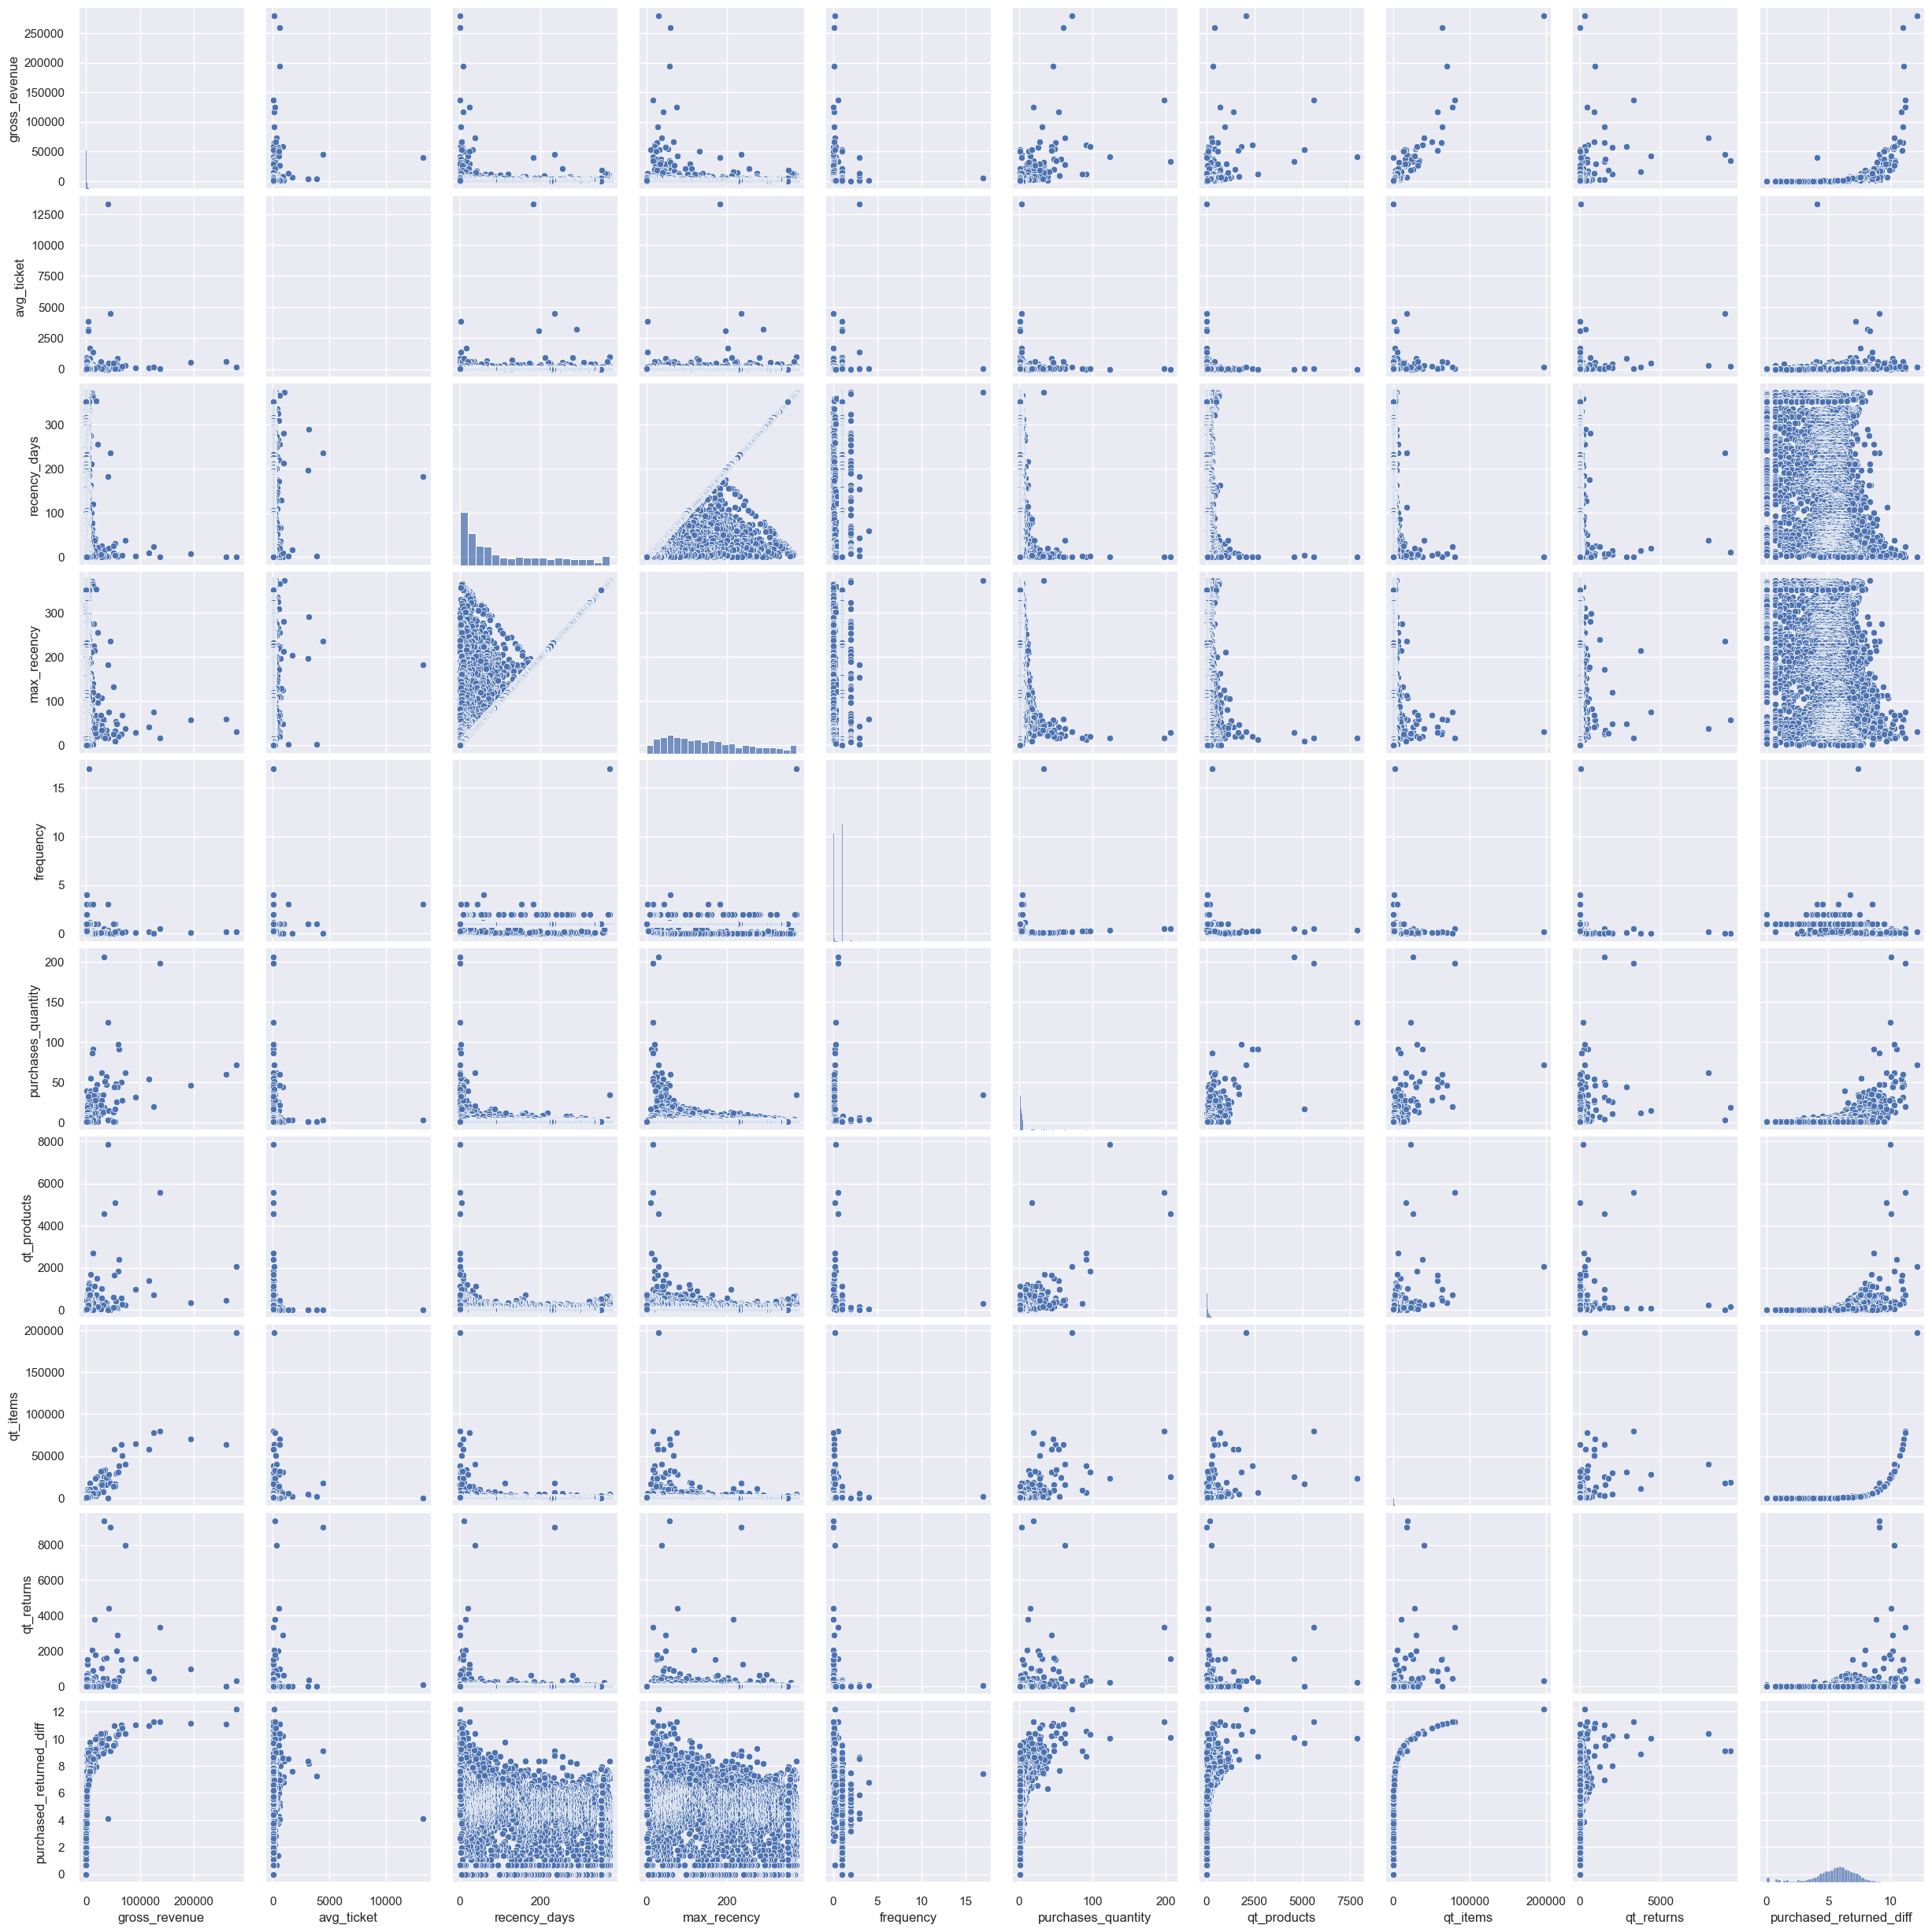

In [47]:
df_bivariate = df5.drop(columns=['customer_id'])
plt.figure(figsize=(25,12))

sns.pairplot(df_bivariate)

The avg_ticket variable has low variance.

## 6. **Data Preparation**

In [48]:
df6 = df5.copy()
df6.columns

Index(['customer_id', 'gross_revenue', 'avg_ticket', 'recency_days',
       'max_recency', 'frequency', 'purchases_quantity', 'qt_products',
       'qt_items', 'qt_returns', 'purchased_returned_diff'],
      dtype='object')

There are mainly two Feature Scaling methods in ML: Rescaling and Standardization. **Rescaling** uses either Robust Scaler, which is used to deal with outliers:

${x}' =  \frac{x_{i} - Q_{1}(x)}{Q_{3}(x)- Q_{1}(x)}$

or Min Max Scaler, which can be used when no significant outliers are present a:

${x}' =  \frac{x - x_{min}}{x_{max} - x_{min}}$

In the other hand, **Standardization** is applied when the variable follows an approximately normal distribution and no significant outliers are present:

${x}' =  \frac{x_{i} - \mu}{\sigma}$

*${x}'$ is the new value for each observation*

In order to select which transformation to use two tests will be performed for each variable to check for normality:
- Q–Q (Quantile-Quantile) Plot
- KS (Kolmogorov–Smirnov) Test

And to check for outliers the following tasks will be performed:
- Box Plots

Then, as a *rule of thumb** , if variable X is:
- **Approximately normally distributed and no significant outliers are present -> Standard Scaler**
- **Approximately normally distributed and significant outliers are present -> Robust Scaler**
- **Not normally distributed -> Min Max Scaler**

**results can be better with other scalers, it's important to test them.*

#### 6.1. **Checking for Normal Distributions and Outliers**

6.1.1 **Normality Check**

<AxesSubplot:title={'center':'frequency'}, xlabel='Theoretical quantiles', ylabel='Ordered Values'>

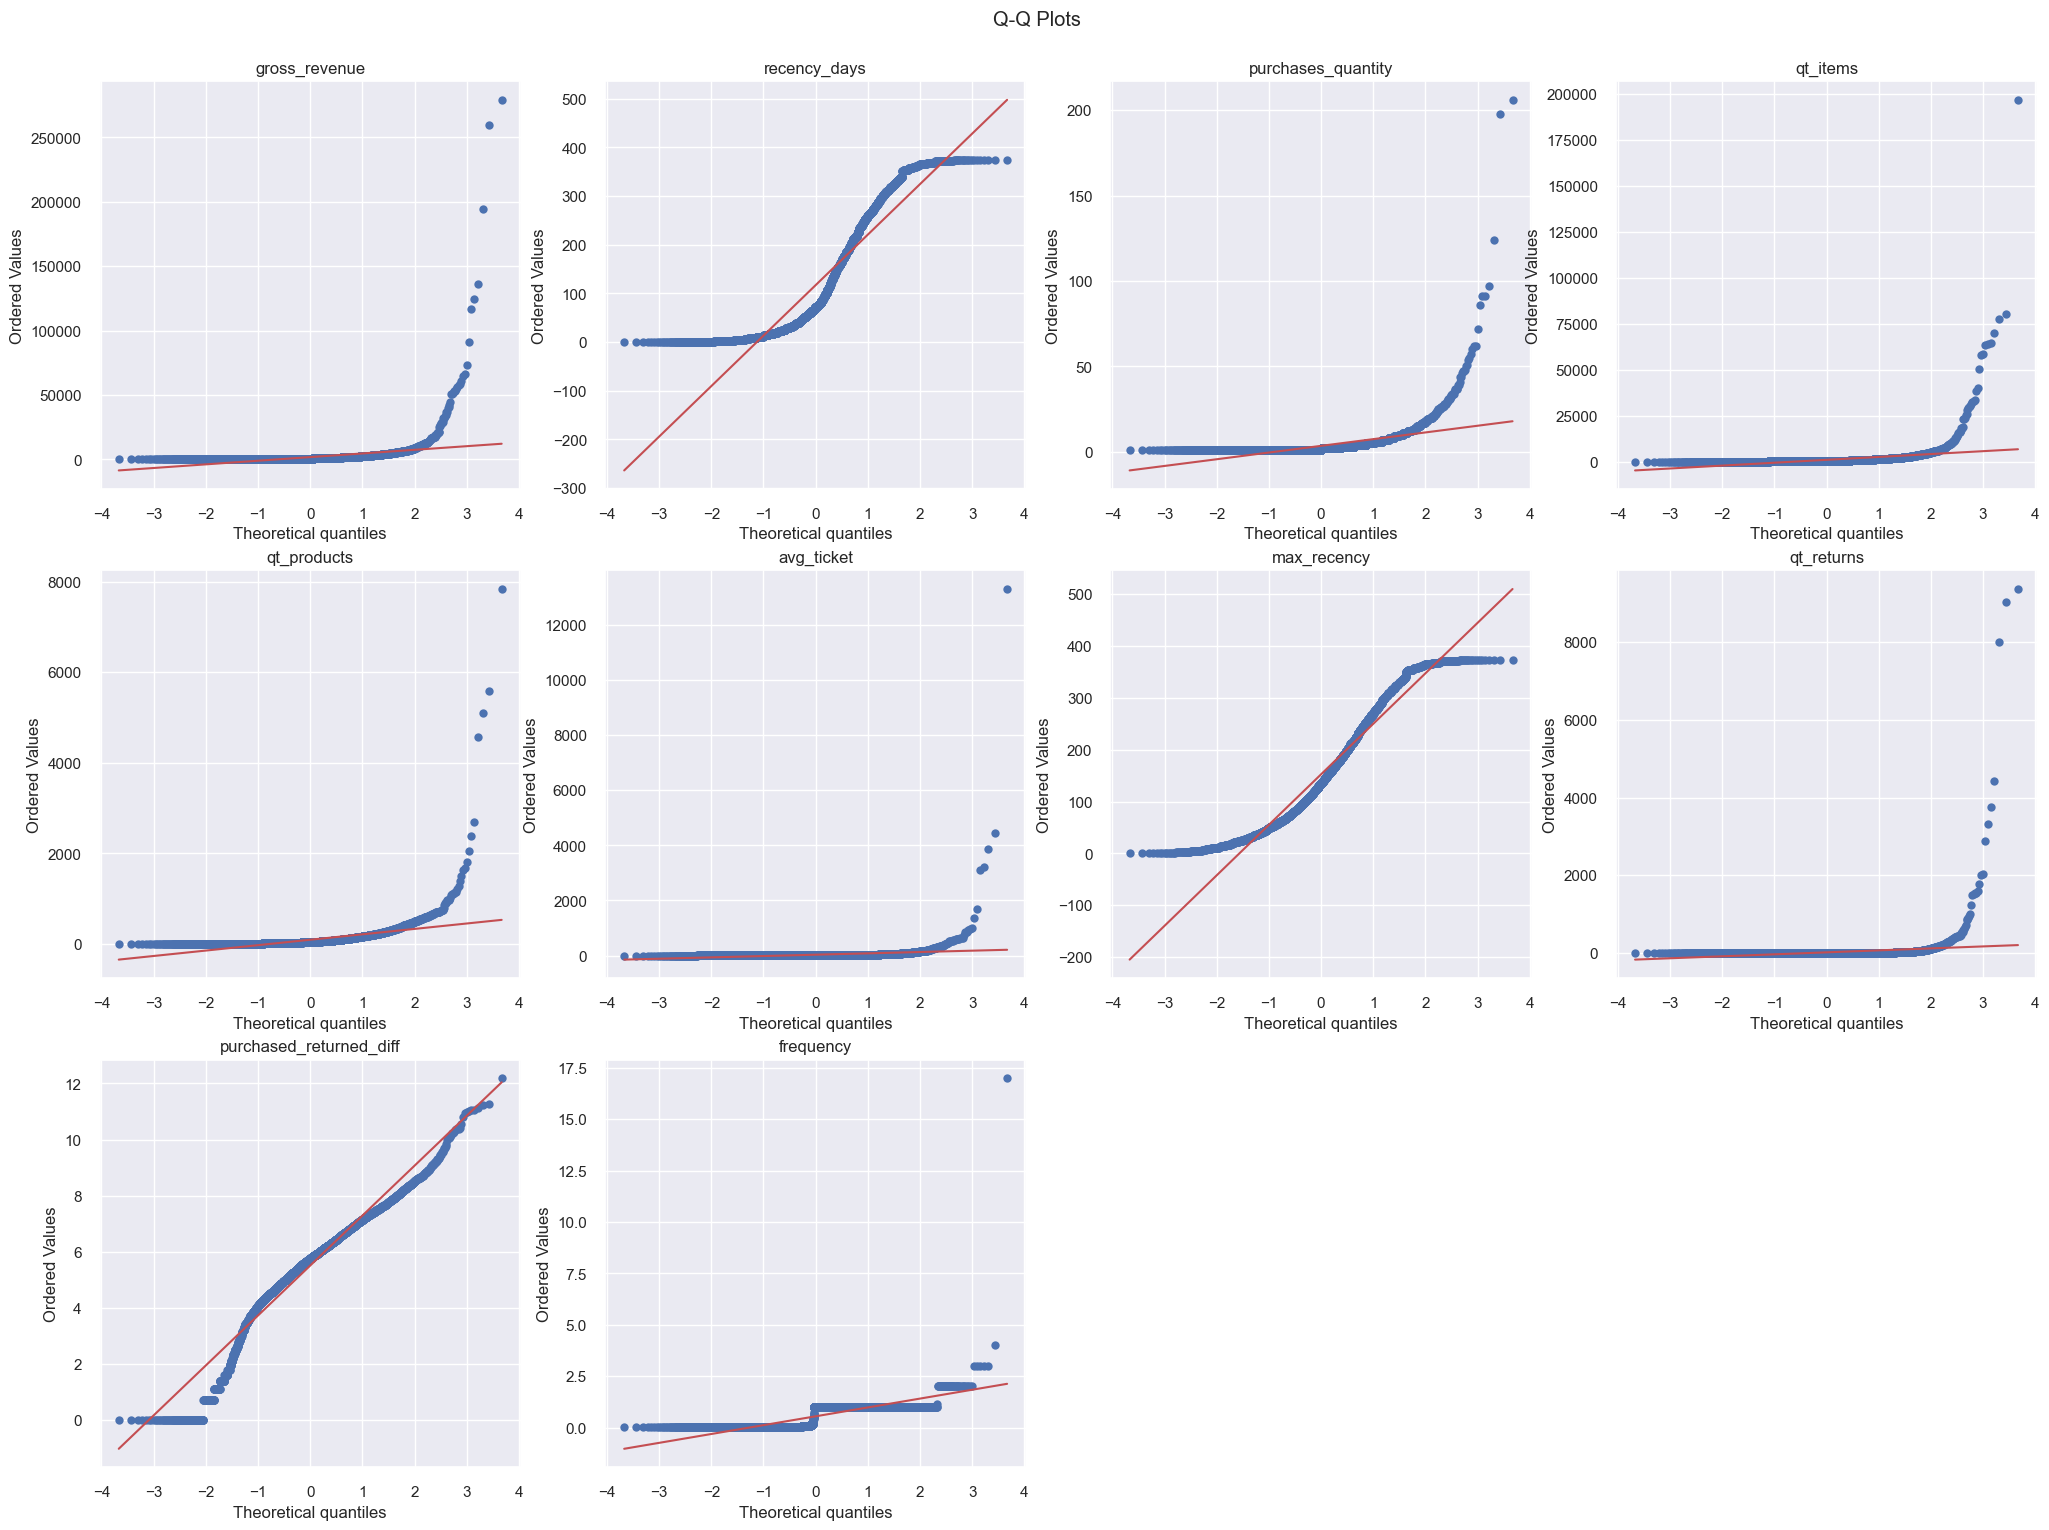

In [49]:
variables = ['gross_revenue', 'recency_days', 'purchases_quantity',
       'qt_items', 'qt_products', 'avg_ticket', 'max_recency',
       'qt_returns', 'purchased_returned_diff', 'frequency']
             
# QQ Plots
qq_plot(df6, variables)

In [50]:
ks_test(df6, variables)

,variables,statistic,pvalue
0,gross_revenue,0.98946,0.00000
1,recency_days,0.95665,0.00000
2,purchases_quantity,0.84134,0.00000
3,qt_items,0.96631,0.00000
4,qt_products,0.93261,0.00000
5,avg_ticket,0.97025,0.00000
6,max_recency,0.99478,0.00000
7,qt_returns,0.50000,0.00000
8,purchased_returned_diff,0.92010,0.00000
9,frequency,0.50217,0.00000


According to QQ-plots the only two variables that come close to a normal distribution are recency_days and 	purchased_returned_diff. However, just like every other variable in the dataset, their p-values are less than 0.05, meaning there is enough evidence to assume that none of the variables are normally distributed. 

6.1.2 **Outlier Check**

<AxesSubplot:title={'center':'frequency'}>

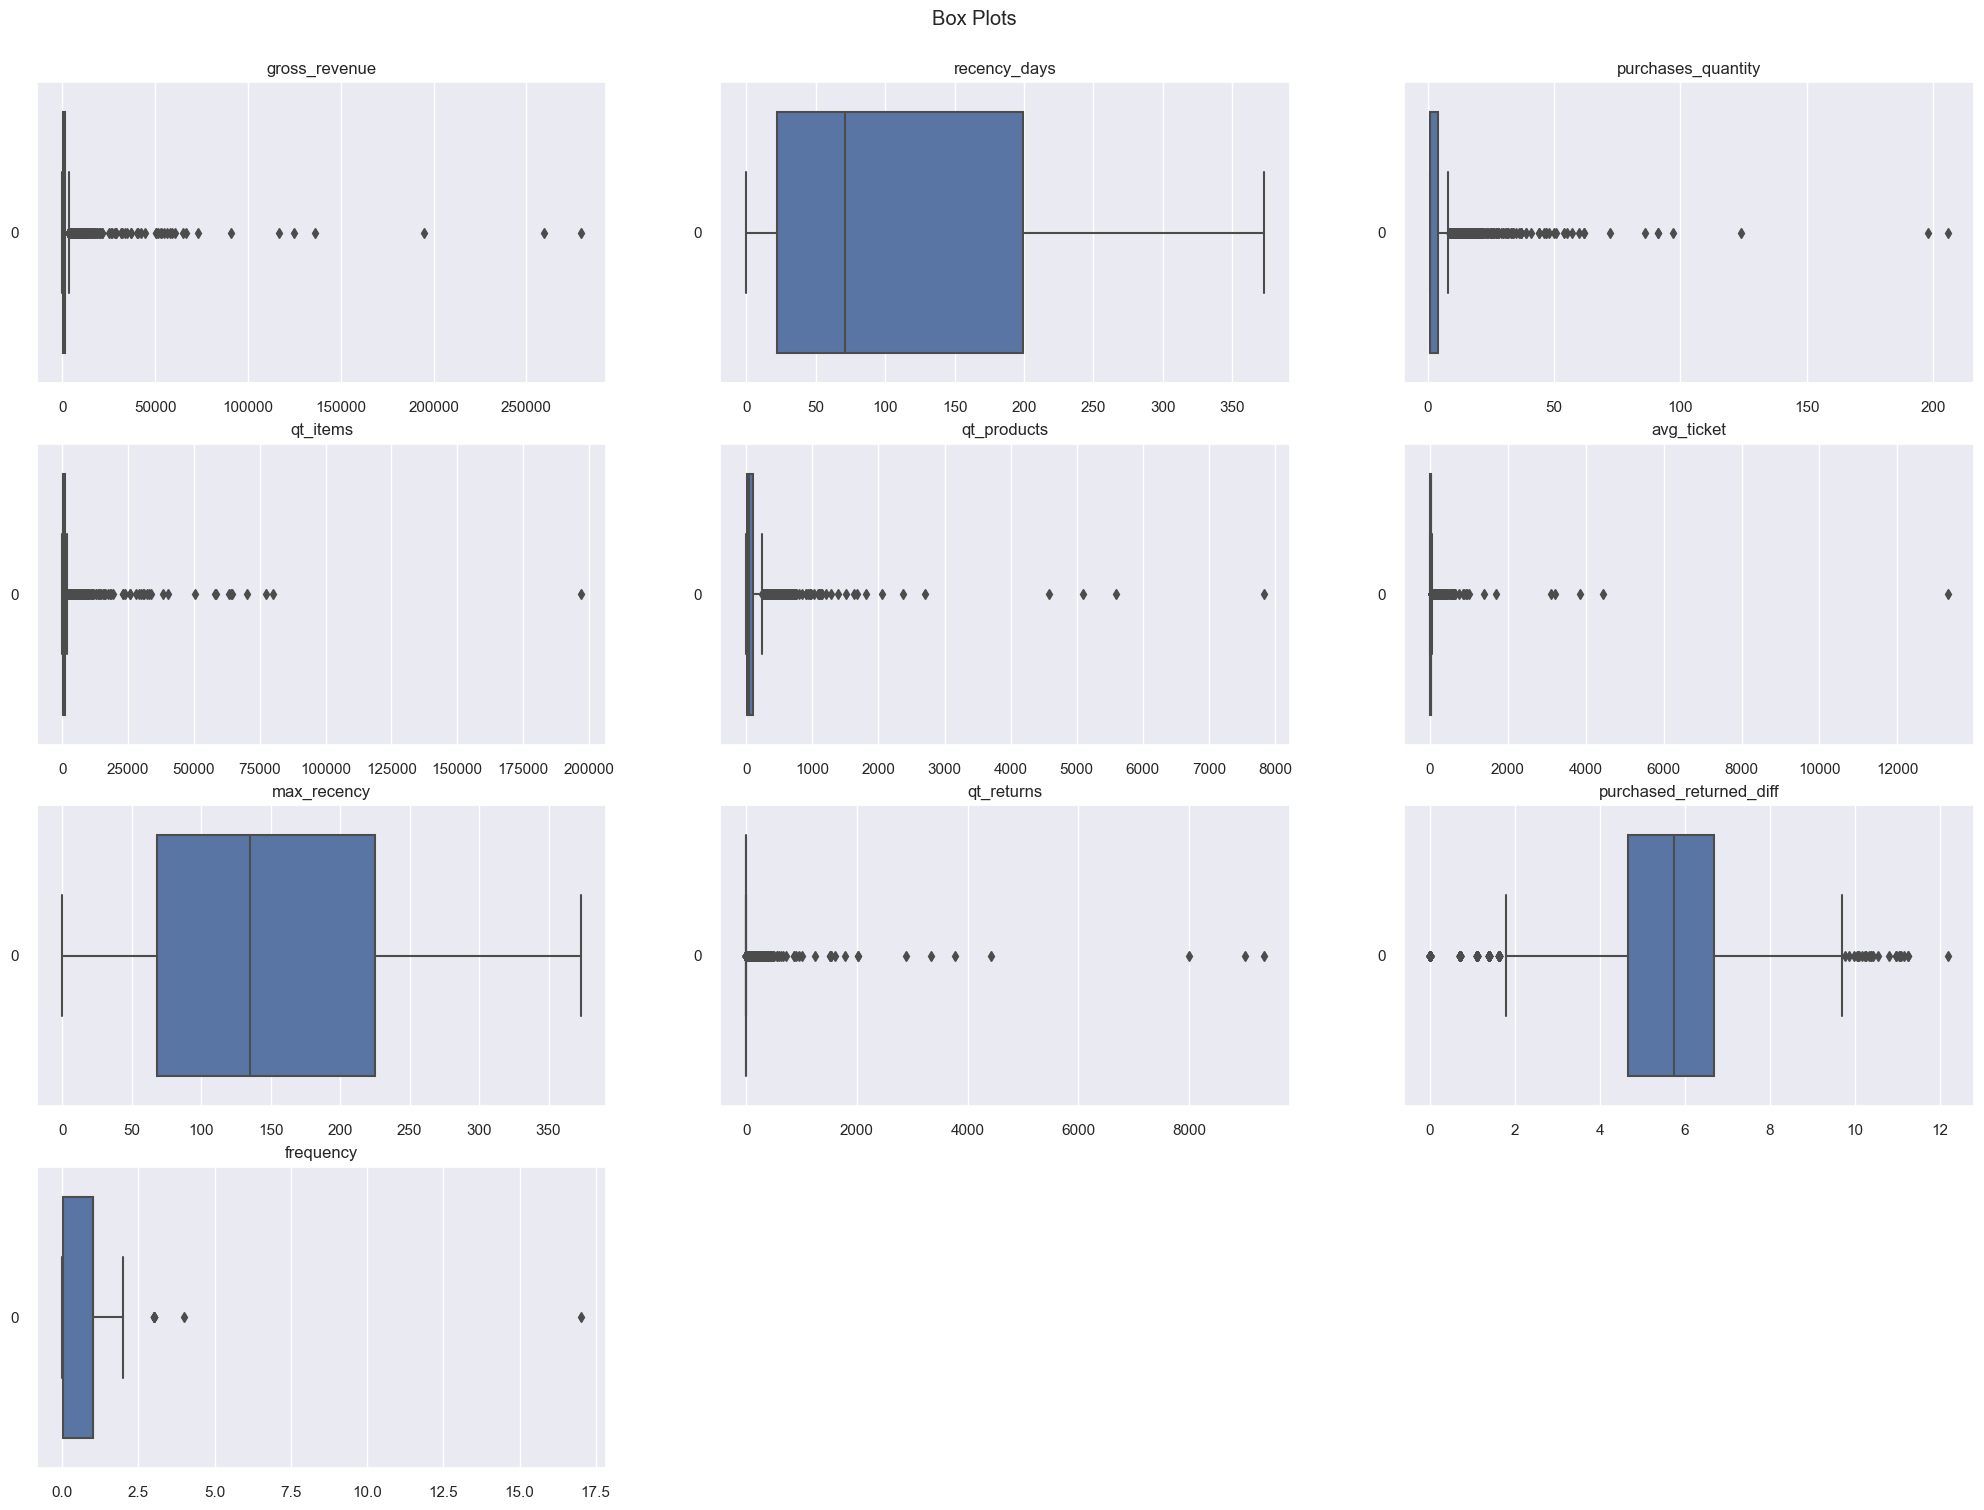

In [51]:
box_plots(df6, variables, a=4, b=3)

As all variables have significant outliers present and none of them are normally distributed **Min Max Scaler** will be applied for every one of them. 

#### 6.2. **Rescaling**

In [52]:
cols = ['gross_revenue', 'recency_days', 'purchases_quantity',
       'qt_items', 'qt_products', 'avg_ticket', 'max_recency',
       'qt_returns', 'purchased_returned_diff', 'frequency']

mm = MinMaxScaler()

for i in cols:
    df6[cols] = mm.fit_transform(df6[cols].values)

In [53]:
# df6['gross_revenue'] = mm.fit_transform(df6[['gross_revenue']])
# df6['recency_days'] = mm.fit_transform(df6[['recency_days']])
# df6['purchases_quantity'] = mm.fit_transform(df6[['purchases_quantity']])
# df6['avg_ticket'] = mm.fit_transform(df6[['avg_ticket']])
# df6['qt_returns'] = mm.fit_transform(df6[['qt_returns']])
# df6['qt_items'] = mm.fit_transform(df6[['qt_items']])
# df6['qt_products'] = mm.fit_transform(df6[['qt_products']])
# df6['frequency'] = mm.fit_transform(df6[['frequency']])

## 7. **Feature Selection**

Feature selection can be a tricky task in clustering problems. For this project, we looked into pairplots to determine features with low variance and found avg_ticket to have such behavior. In addition to that, we'll be looking at Pearson correlation amongst variables, and gross_revenue will be treated as a target variable in this case, so it becomes a supervised problem. This is important when Tree-based embedding is applied latter on.

In [54]:
df7 = df6.copy()

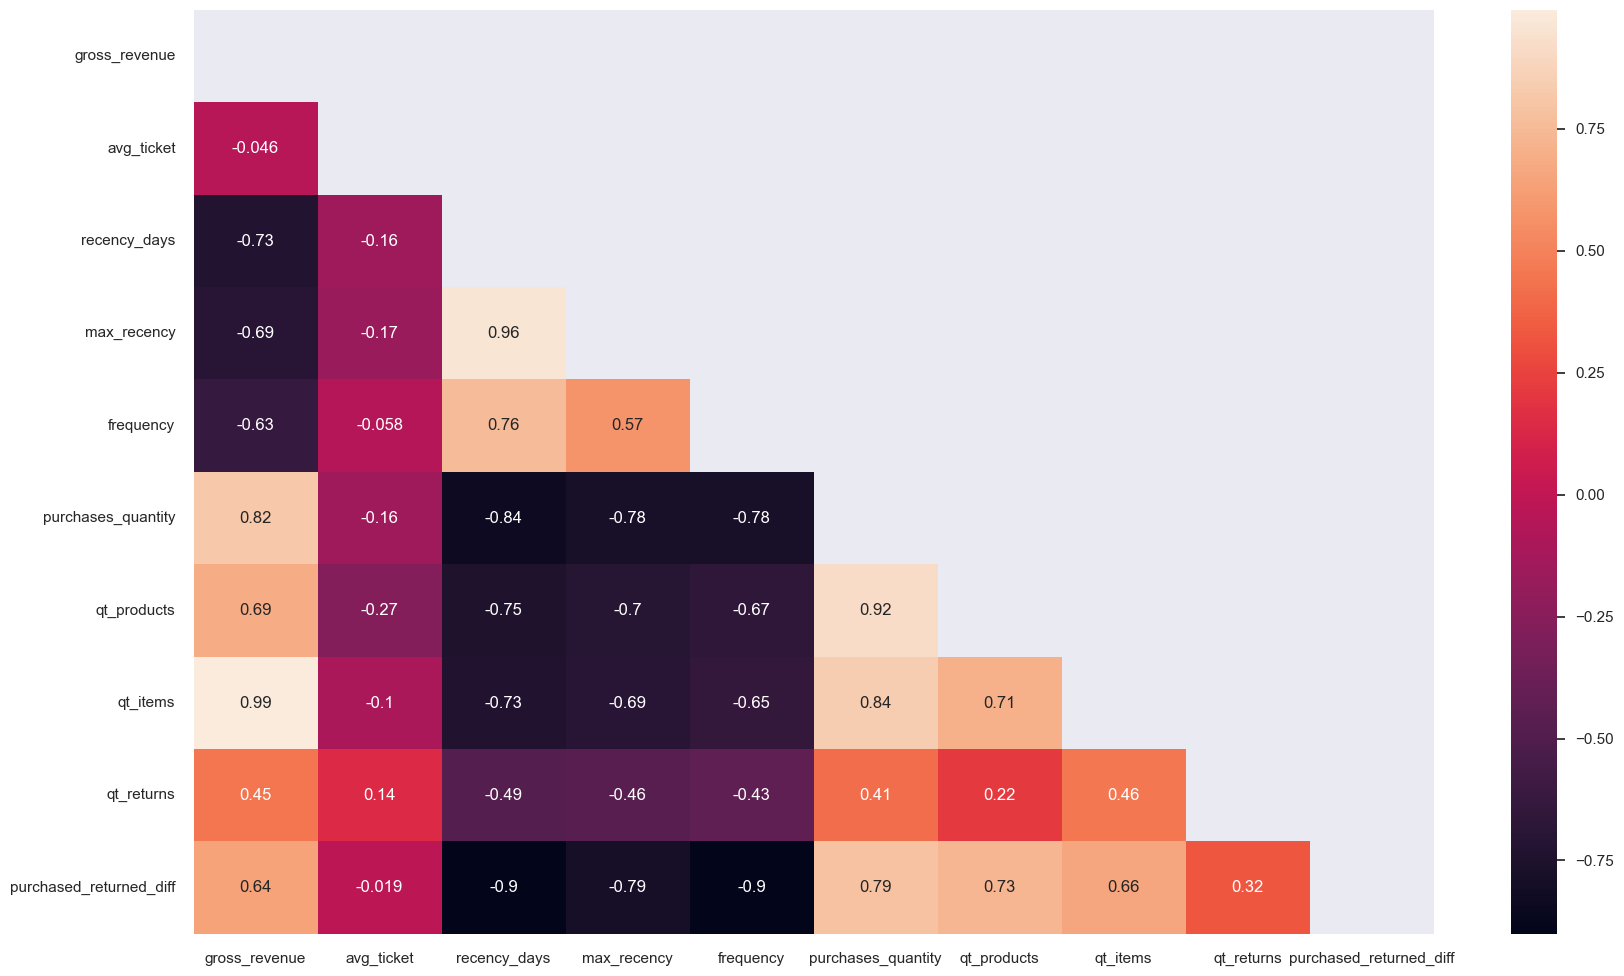

In [55]:
X = df7.drop(columns=['customer_id'])
corr = X.corr(method='pearson').corr() # Pearson Corr
mask = np.triu(corr) # Cleaner heatmap - Only plotting the lower triangle

plt.figure(figsize=(20,12)) # Heatmap size
sns.heatmap(corr, annot=True, mask=mask);

**Overall analysis:** 
- max_recency and recency_days have high correlation **->** max_recency will be removed, since it's the lowest correlation in absolute values to gross_revenue amongst the two (-0.69 vs -0.73).
- qt_products and purchases_quantity have high correlation **->** qt_products will be removed, since it's the lowest correlation in absolute values to gross_revenue amongst the two (0.69 vs 0.82).
- purchased_returned_diff and frequency have high correlation **->** frequency will be removed, since it's the lowest correlation in absolute values to gross_revenue amongst the two (-0.63 vs 0.64).

**Target variable (gross_revenue) analysis:** 
- avg_ticket has low correlation to gross_revenue **->** avg_ticket will be removed, as it was also previously found to be a low variance variable when pairplots were looked into. 

In [56]:
cols_not_selected = ['avg_ticket', 'max_recency', 'qt_products', 'frequency']
df7 = df7.drop(cols_not_selected, axis=1).copy()

## 8. **Space Analysis and Dimensionality Reduction**

In [57]:
df8 = df7.copy()
X = df8.drop(columns=['customer_id'])
data_shape(X)

Number of Rows: 5690
Number of Columns: 6


To get a better data separation a few dimensionality reduction techniques will be tested.

#### 8.1. **PCA**

<BarContainer object of 6 artists>

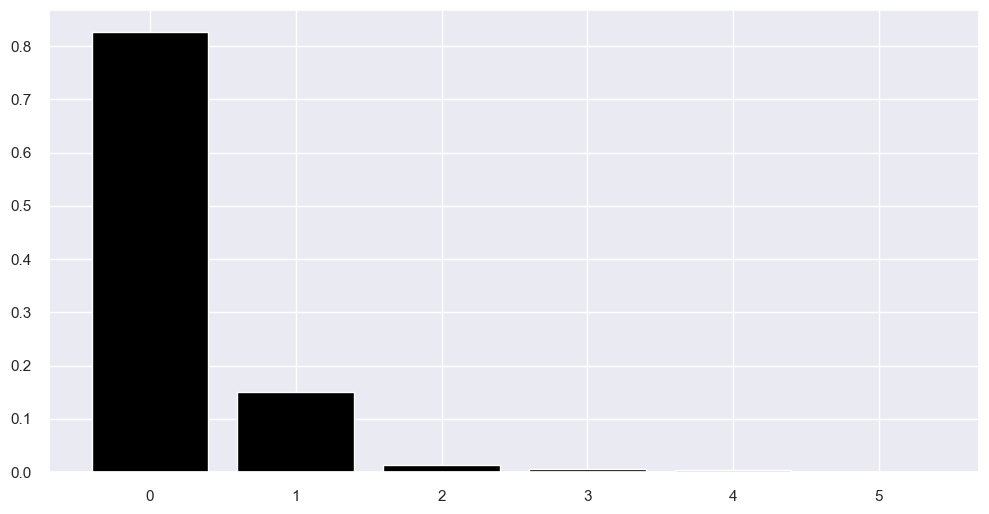

In [58]:
pca = PCA(n_components=X.shape[1])
principal_components = pca.fit_transform(X)

df_pca = pd.DataFrame(principal_components)

features = range(pca.n_components)
plt.bar(features, pca.explained_variance_ratio_, color='black')

#### 8.2. **Uniform Manifold Approximation and Projection (UMAP)**

<p align="justify"> UMAP, just like t-SNE, is a non-linear dimensionality reduction technique. Both these methods capture non-linear structure in high dimensional data, which means that if two points are close in the high dimensional space, they have a high probability of being close in the low dimensional space. Nonetheless, UMAP usually works better in comparison to t-SNE, because it's much faster, captures the global structure better, and it can be used in data preprocessing for later use in ML models, while t-SNE's use is mostly data visualization. </p>

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

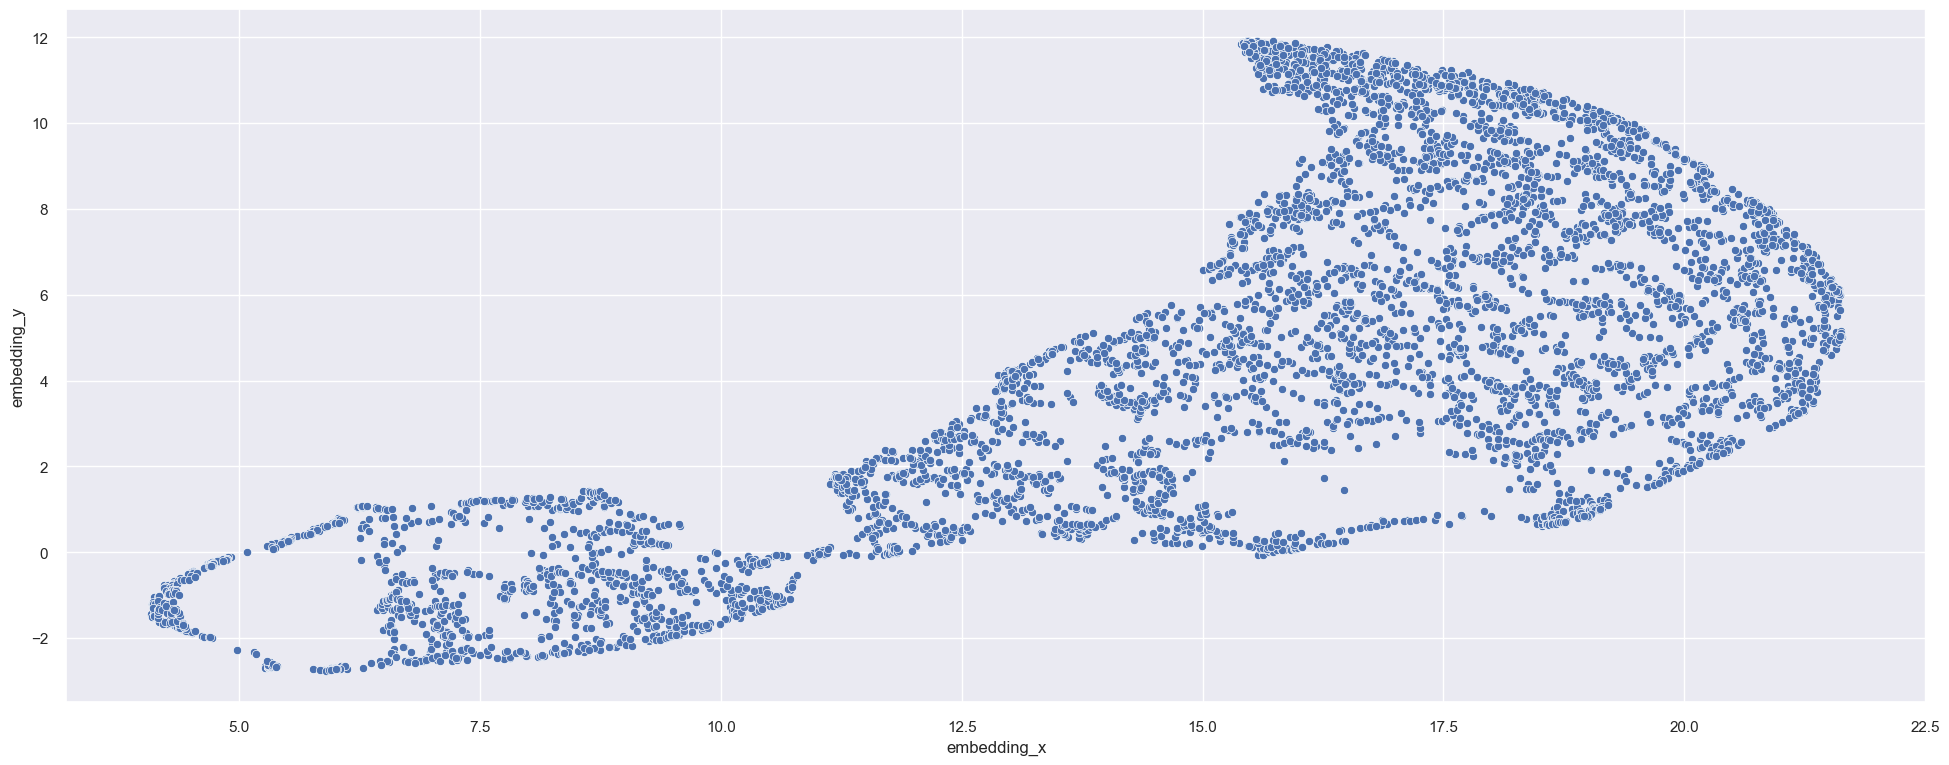

In [59]:
# Reducing Dimensionality
reducer = umap.UMAP(n_neighbors=200, 
                    random_state=42, 
                    metric='manhattan', 
                    n_epochs=450)                    
embedding = reducer.fit_transform(X) # reducing dimensionality to 2d
df_umap = pd.DataFrame()

# Embedding
df_umap['embedding_x'] = embedding[:, 0] # x component
df_umap['embedding_y'] = embedding[:, 1] # y component

# Plotting
plt.figure(figsize=(24,9))
sns.scatterplot(x='embedding_x', 
                y='embedding_y',
                data=df_umap)

As seen above UMAP on its on does't really help separating our data into clusters, hence the use of Tree-Based Embedding.

#### 8.3. **Tree-Based Embedding**

This technique consists of:

- Setting gross_revenue as a response variable, so it becomes a supervised learning problem. 
- Training a Random Forest (RF) model to predict gross_revenue using all other features.
- Plotting the embedding based on RF's leaves.

In [60]:
# Training Data
X = df8.drop(columns=['customer_id', 'gross_revenue'])
y = df8['gross_revenue'].copy()

# Model Definition
rf_model = RandomForestRegressor(n_estimators=100, 
                                 min_samples_split=32,                                 
                                 n_jobs=-1,
                                 random_state=42)
# Model Training
rf_model.fit(X, y)

# DataFrame Leaf
df_leaf = pd.DataFrame(rf_model.apply(X)) # Apply trees in the forest to X, return leaf indices.           

**UMAP with Random Forest**

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

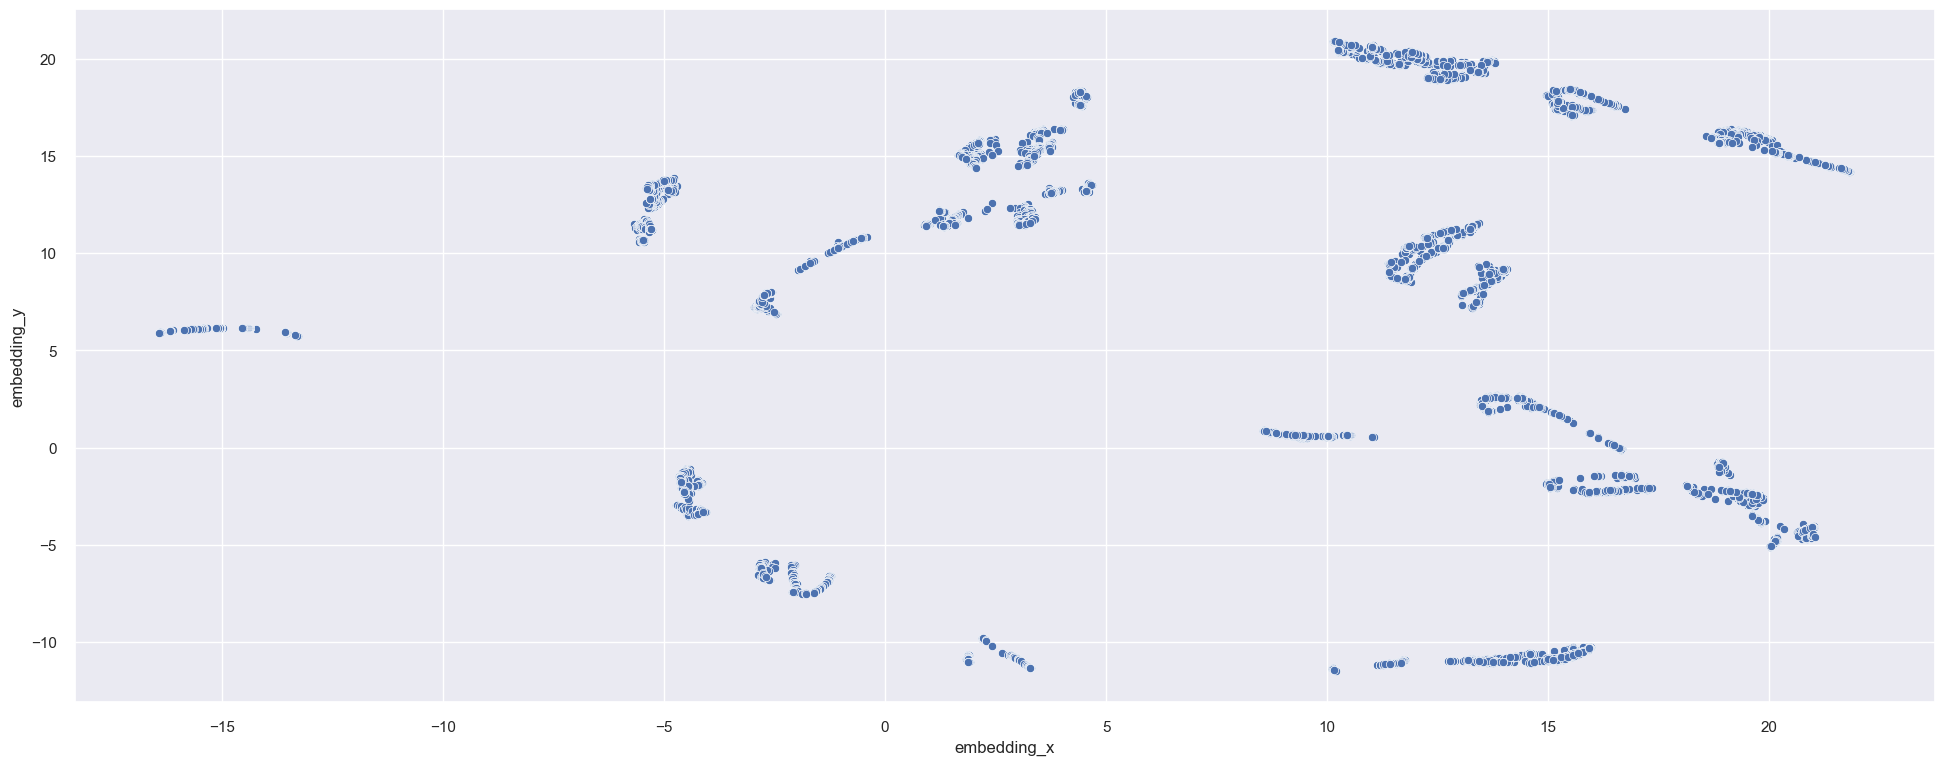

In [61]:
# Reducing Dimensionality
reducer = umap.UMAP(n_neighbors=200, 
                    random_state=42, 
                    metric='manhattan', 
                    n_epochs=450)

embedding = reducer.fit_transform(df_leaf) # reducing dimensionality to 2d     
df_tree = pd.DataFrame()

# Embedding
df_tree['embedding_x'] = embedding[:, 0] # x component
df_tree['embedding_y'] = embedding[:, 1] # y component

# Plotting
plt.figure(figsize=(24,9))
sns.scatterplot(x='embedding_x', 
                y='embedding_y',
                data=df_tree)

Tree-Based Embedding alongside UMAP provided a satisfactory result in splitting data, therefore we'll be using this new space to create the clusters.

In [62]:
# Rescaling df_tree firstly
cols = ['embedding_x', 'embedding_y'] 

mm = MinMaxScaler()

for i in cols:
    df_tree[cols] = mm.fit_transform(df_tree[cols].values)

## 9. **Machine Learning Modeling**

In [63]:
df9 = df_tree.copy() # setting the embedding as our new working space
X = df9.copy() 

clusters = np.arange(2, 25, 1) # Setting the number of possible clusters - lets use from 2 to 24

**In clustering problems, the hyperparameter tuning comes before modelling, as we're selecting the number of clusters (K) for most models.** There're two properties we look for when creating clusters:

- **Compactness**: Observations from the same cluster must be compact with one another, meaning the distance between them should be as small as possible.

- **Separation**: Different clusters must be as far apart from one another as possible.

**Therefore, to choose K we'll be looking into those via the Silhouette Score:**

- Silhouette Score evaluates both **Separation** and **Compactness**. 
- It goes from -1 to 1, the higher the better. 

#### 9.1. **K-Means**

**How does it work?**

- Firstly $k$ is selected, where $k$ is the number of clusters.
- Each cluster center is randomly initialized, where its value is the mean of all points within the cluster.
- Each point is classified accordingly to the lowest distance between that point and each cluster center.
- Every time the points are reassigned the new clusters' centers are recalculated. 
- This process can occur $N$ times (*max_iter* parameter in sklearn).

**Advantages:**
- Faster than other clustering algorithms.
- Ensures convergency.

**Disadvantages:**
- $k$ has to be chosen manually.
- Results may be different depending on where the clusters are initially placed (this can be partially countered by the *n_init* parameter in sklearn).
- Outlier sensitive.

In [64]:
kmeans_list, kmeans_labels = silhouette_score_loop(X, clusters, km=True)

<AxesSubplot:title={'center':'Silhouette Score x K'}, xlabel='K', ylabel='Silhouette Score'>

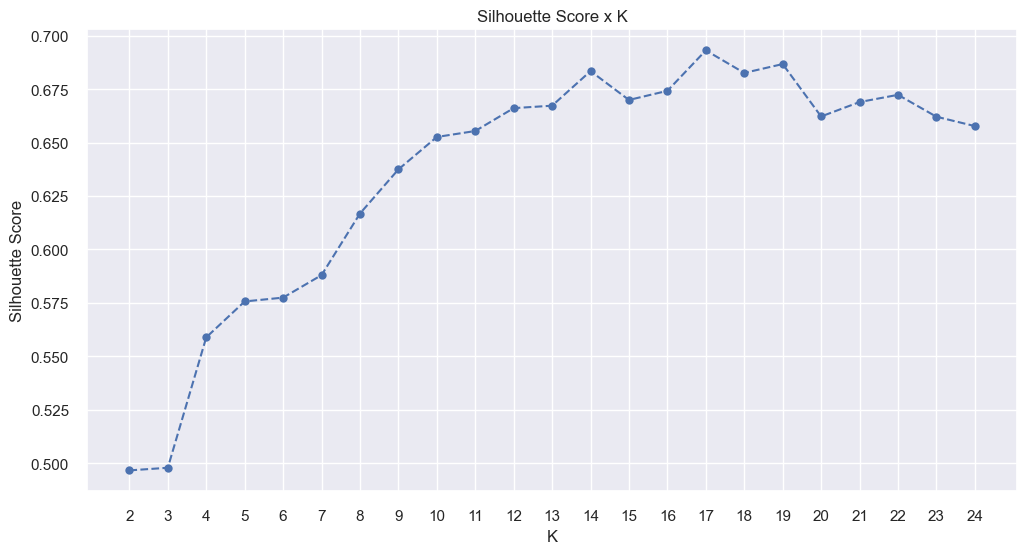

In [65]:
silhouette_line_plot(clusters, kmeans_list) # plotting the performance for each k

#### 9.2. **Gaussian Mixture Models (GMM) with Expectation–Maximization (EM)**

**How does it work?**

- *Initial assumptions*: All data points are Gaussian distributed, and both parameters (mean and standard deviation) of each cluster are calculated by the Expectation–Maximization (EM) algorithm.
- Firstly $k$ is selected, where $k$ is the number of clusters.
- The parameters of each cluster are randomly initialized.
- Each point is classified accordingly to the probability (based on Gaussian distributions) of that point belonging to a particular cluster.
- Every time the points are reassigned the new clusters' parameters are recalculated. 
- This process can occur N times (*max_iter* parameter in sklearn).

**Advantages:**
- Flexible in terms of cluster shape, since those can be elliptical. 
- It can add uncertainty on each data points, as it's probability-based. This is useful whenever a data point is right in the middle of two clusters.

**Disadvantages:**
- k has to be chosen manually.
- Results may be different depending on where the clusters are initially placed (this can be partially countered by the *n_init* parameter in sklearn).
- High computational cost.

In [66]:
gmm_list, gmm_labels = silhouette_score_loop(X, clusters, gmm=True)

<AxesSubplot:title={'center':'Silhouette Score x K'}, xlabel='K', ylabel='Silhouette Score'>

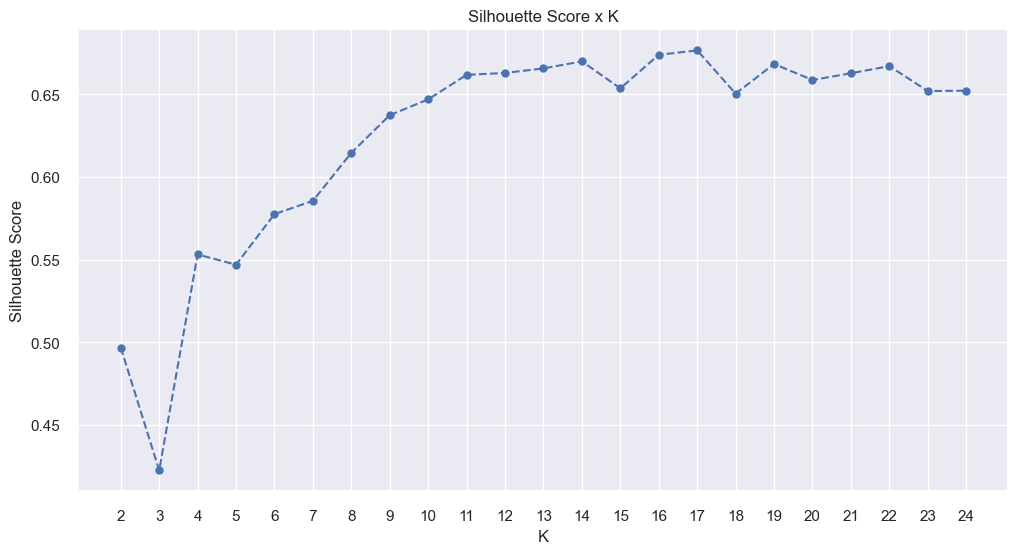

In [67]:
silhouette_line_plot(clusters, gmm_list) # plotting the performance for each k

#### 9.3. **Agglomerative Hierarchical Clustering (HC)**

**How does it work?**

- Each point is initially treated as a cluster.
- The distance between all points are calculated, where this distance can be: 
  - single-linkage
  - complete-linkage
  - average-linkage
  - group-linkage
  - ward's method
- The nearest neighbors are assigned to the same cluster.
- This process is repeated until all data points belong to the same cluster.
- Then, the number of clusters ($k$) can be chosen, meaning we can cut the cluster split wherever we want. 

*That's why this algorithm is hierarchical, as the hierarchy of clusters is represented as a dendrogram, where its top gathers all data points.*

**Advantages:**
- Defining the number of clusters initially isn't required, since this can be determined in the end. 
- Not sensitive in terms of distance metric choice (all metrics lead to similar results).

**Disadvantages:**
- Outlier sensitive.
- High computational cost.

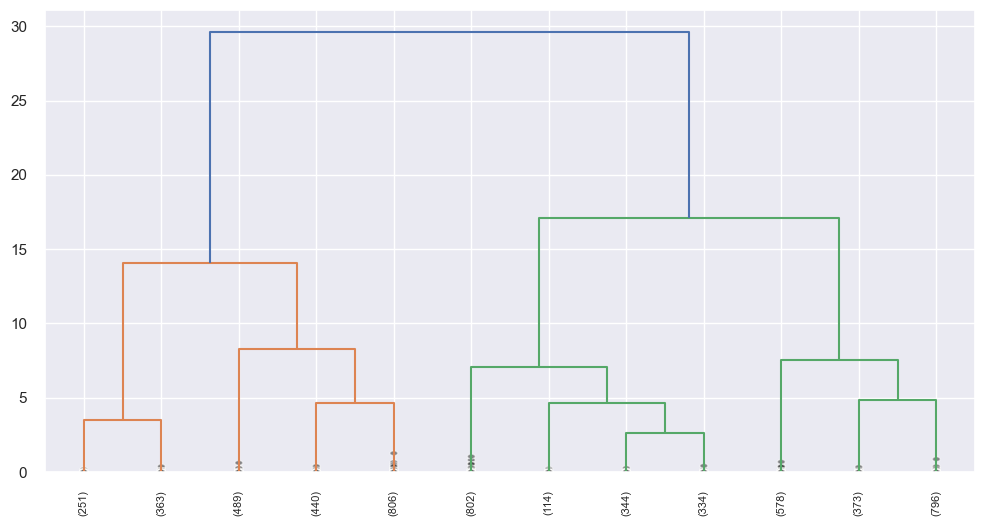

In [68]:
# Defining and training the model
hc_model = linkage(X, 'ward')

dendrogram(
    hc_model,  
    truncate_mode='lastp', # better visualization
    p=12,
    leaf_rotation=90,
    leaf_font_size=8,
    show_contracted=True
)
plt.show()

Just like the other models we'll pass a list o k's, however those are to evaluate model performance for each k, while for the other models those were to fit the model for each k.

In [69]:
hc_list, hc_labels = silhouette_score_loop(X, clusters, hc=True)

<AxesSubplot:title={'center':'Silhouette Score x K'}, xlabel='K', ylabel='Silhouette Score'>

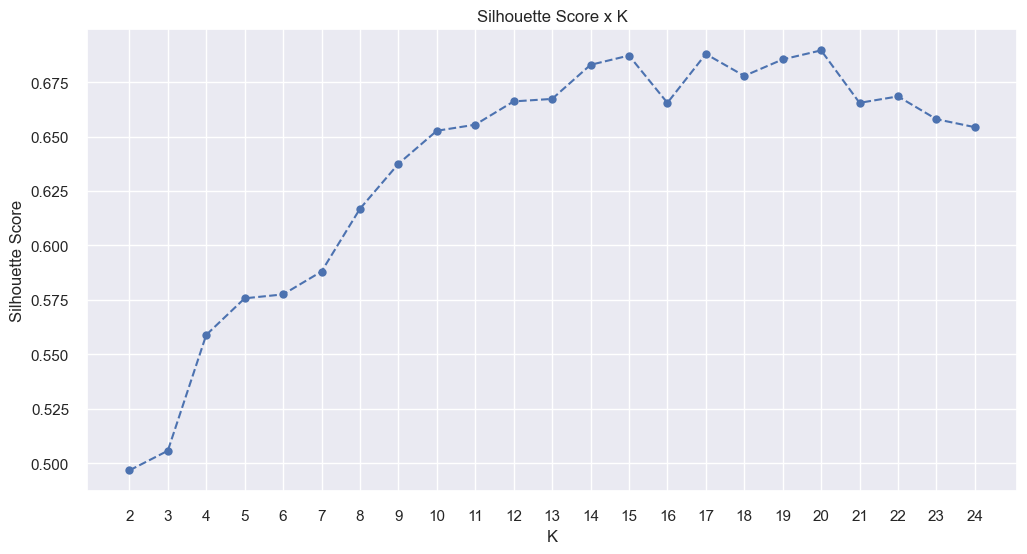

In [70]:
silhouette_line_plot(clusters, hc_list) # plotting the performance for each k

#### 9.4. **Density-based Spatial Clustering of Applications with Noise (DBSCAN)**

**How does it work?**

- Firstly two parameters are defined: a radius $\epsilon$ and the minimal number of points inside the neighborhood, let's call it $N$. 
- Then, DBSCAN assigns the data points to three classes like so:
  - **"core point"** if point X inside a neighborhood of radius $\epsilon$ has its number of points greater than $N$. 
  - **"border point"** if point X inside a neighborhood of radius $\epsilon$ has its number of points smaller than $N$, but it contains at least one **"core point"**.
  - **"noise point"** if point X inside a neighborhood of radius $\epsilon$ has its number of points smaller than $N$, and it does't contain any **"core point"**.
- Once the points are assigned DBSCAN will create the clusters accordingly to the points classes:
  - If point X is a **"core point"** and it's not assigned to any cluster then create a new cluster and assign X to it; else if there's a **"core point"** Y assigned to a cluster and Y is within X's neighborhood then X is assigned as the same cluster that Y belongs to.
  - If X is a **"border point"** firstly find the closest **"core point"** (let's call it Z), then X is assigned to the same cluster Z belongs to. 
  - If X is a **"noise point"** nothing happens, as it's a outlier/random noise.

**Advantages:**
- Defining the number of clusters ($k$) isn't required, DBSCAN will provide $k$ in the end.
- Robust to outliers.
- Quite flexible in terms of cluster shape.

**Disadvantages:**
- There's a need to define two parameters at first: $\epsilon$ and $N$. And it can be difficult to optimize them.
- Not the best at separating clusters with different densities.

<p align="justify"> To fix one of DBSCAN's problems, which is to optimize eps and min_samples parameters, <b>Bayesian Optimization</b> will be applied, by using the <a href="https://optuna.org/">Optuna</a> library. This is how it works:

- A set of possible model hyperparameters (search space) is defined.
  
- It starts searching random combinations of these parameters and training each model.
  
- Then, Optuna uses a history record of trials to determine which hyperparameter values to try next, by trying to find the most promising hyperparameters to be tuned.
  
- The metrics for each model are saved for latter comparison.

Bayesian Optimization is definitely more efficient in comparison to Grid Search and Random Search, since it's much faster than Grid Search, and it goes through better (smarter) hyperparameters combination than Random Search, meaning that it considers hyperparameters differently in terms of model impact. </p>

In [71]:
# # Defining an objective function to be optimized
# def bayesian_opt_objective(trial):
#     eps = trial.suggest_float('eps', 0.01, 0.09, step=0.005)
#     min_samples = trial.suggest_int('min_samples', 5, 100, step=5)

#     # Defining the model
#     dbscan_model = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)

#     # Training the model and predicting
#     labels = dbscan_model.fit_predict(X)

#     # Performance
#     sil = silhouette_score(X, labels, metric='euclidean')

#     return sil

In [72]:
# study = optuna.create_study(direction='maximize') # maximizing the precision at k
# study.optimize(bayesian_opt_objective, n_trials=1000); # optimizing the defined function and setting the number of trials
# trial = study.best_trial

# print(f'Best Silhouette Score = {trial.value} with K = {len(set(labels))}')
# print(f'Best Hyperparameters = {trial.params}')

In [73]:
# Best parameters provided
eps = 0.025
min_samples = 20

# Defining the model
dbscan_model = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)

# Training the model and predicting
dbscan_labels = dbscan_model.fit_predict(X)

# Performance
dbscan_sil = silhouette_score(X, dbscan_labels, metric='euclidean')

print(f'Number of Clusters : {len(set(dbscan_labels))}')
print(f'Silhouette Score : {dbscan_sil}')

Number of Clusters : 21
Silhouette Score : 0.656814455986023


#### 9.5. **Results**

To choose a final model let's evaluate silhouette scores for all models and k values. To do so there's no need to pick the highest score for each model necessarily, since the clustering process has to be useful for Outleto's Marketing Team, and 23 clusters for instance wouldn't be practical. That's why we won't be considering DBSCAN as a final model contester. Lets then set our maximum cluster number choice to 11. 

In [74]:
df_results = pd.DataFrame(
    {'KMeans': kmeans_list,
    'GMM': gmm_list,
    'HC': hc_list
    }).T

df_results.columns = clusters
df_results.style.highlight_max(color='blue', axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.496679,0.497907,0.558901,0.575699,0.577493,0.588007,0.616811,0.637455,0.652629,0.655420,0.666117,0.667259,0.683447,0.669944,0.674213,0.693129,0.682589,0.686733,0.662217,0.668959,0.672345,0.662107,0.657723
GMM,0.496679,0.422260,0.553047,0.546886,0.577493,0.585555,0.614630,0.637455,0.647006,0.661883,0.663029,0.665772,0.670041,0.653699,0.674014,0.676694,0.650500,0.668462,0.658746,0.662845,0.667151,0.652059,0.652278
HC,0.496679,0.505693,0.558901,0.575699,0.577493,0.588007,0.616811,0.637455,0.652638,0.655428,0.666125,0.667269,0.682919,0.687188,0.665467,0.687898,0.677825,0.685408,0.689552,0.665465,0.668421,0.657961,0.654291


9.5.1 **KMeans**

0.6168114


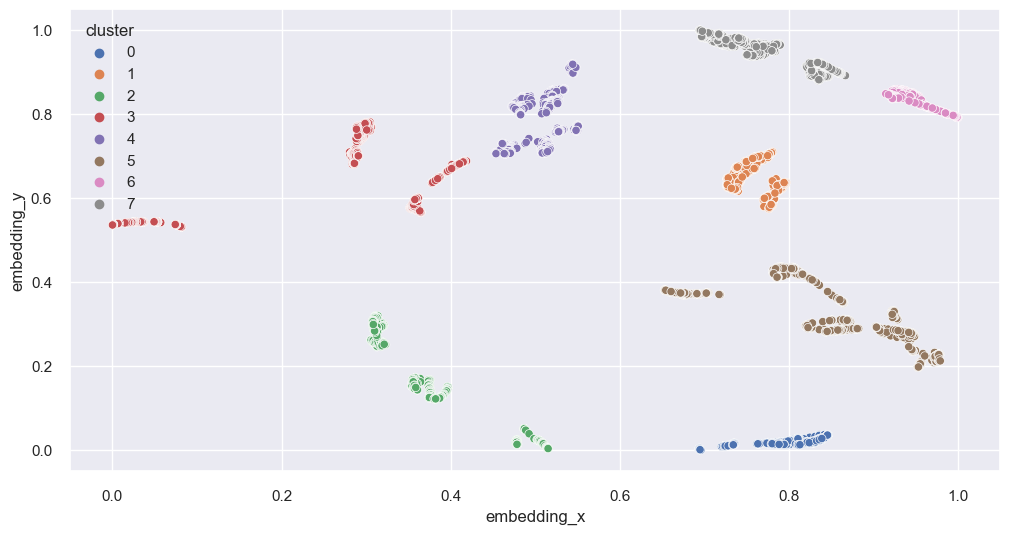

In [75]:
# Defining the model
kmeans_model = KMeans(n_clusters=8, random_state=42)  # 8 to 11 provides good results

# Training the model
kmeans_model.fit(X)

# Predict
kmeans_labels = kmeans_model.predict(X)

# Metrics
kmeans_sil = silhouette_score(X, kmeans_labels, metric='euclidean')

# Clustering
df_results_km = X.copy() 
df_results_km['cluster'] = kmeans_labels # adding the cluster column 

# Plotting the clusters
sns.scatterplot(x='embedding_x', 
                y='embedding_y', 
                hue='cluster', 
                palette='deep', 
                data=df_results_km)
print(kmeans_sil)

9.5.1 **GMM**

0.61463016


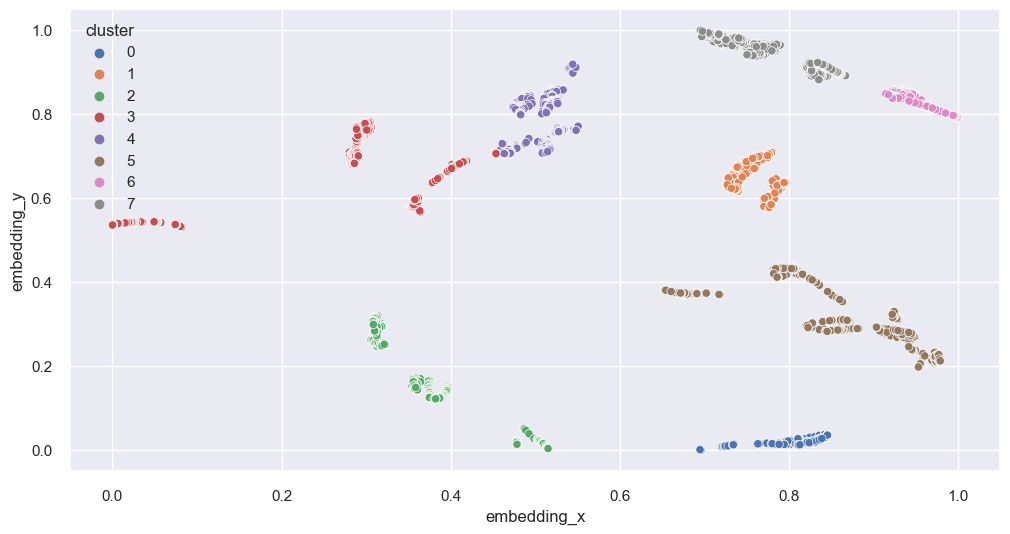

In [76]:
# Defining the model
gmm_model = GaussianMixture(n_components=8, random_state=42) # 8 to 11 provides good results

# Training the model
gmm_model.fit(X)

# Predict
gmm_labels = gmm_model.predict(X)

# Metrics
gmm_sil = silhouette_score(X, gmm_labels, metric='euclidean')

df_results_gmm = X.copy() 
df_results_gmm['cluster'] = gmm_labels # adding the cluster column 

# Plotting the clusters
sns.scatterplot(x='embedding_x', 
                y='embedding_y', 
                hue='cluster', 
                palette='deep', 
                data=df_results_gmm)
print(gmm_sil)           

9.5.1 **HC**

0.6168114


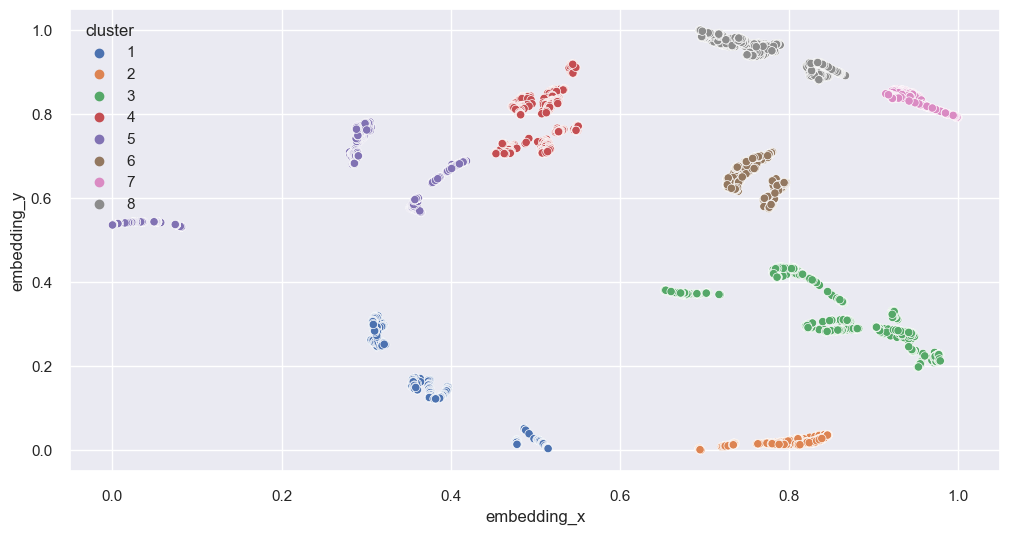

In [77]:
# Defining and training the model
hc_model = linkage(X, 'ward')

# Predict
hc_labels = fcluster(hc_model, 8, criterion='maxclust') # 8 to 11 provides good results

# Metrics 
hc_sil = silhouette_score(X, hc_labels, metric='euclidean')

df_results_hc = X.copy() 
df_results_hc['cluster'] = hc_labels # adding the cluster column 

# Plotting the clusters
sns.scatterplot(x='embedding_x', 
                y='embedding_y', 
                hue='cluster', 
                palette='deep', 
                data=df_results_hc)
print(hc_sil)    

All models perform very similar from 8 to 11 clusters, however **KMeans** will be chosen with **8** clusters, because its silhouette score is slightly better. 

## 10. **Cluster Analysis**

In [78]:
df10 = df_results_km.copy()
df10['cluster'].value_counts()

5    1246
4     802
7     796
3     792
2     614
1     578
0     489
6     373
Name: cluster, dtype: int64

#### 10.1. **Silhouette Visualization**

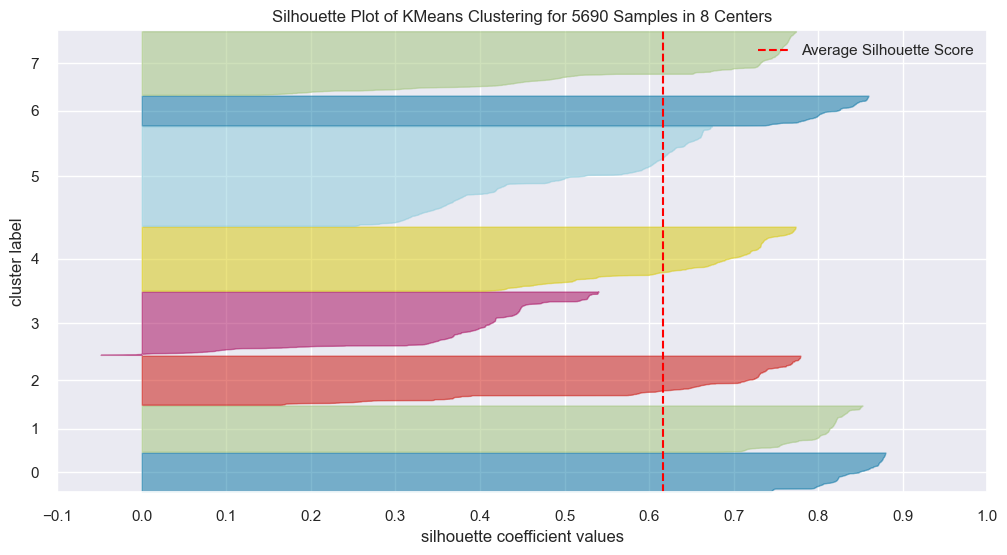

In [79]:
visualizer = SilhouetteVisualizer(kmeans_model, colors='yellowbrick')
visualizer.fit(X).finalize()

The Silhouettes look fine, apart from one point in the pink cluster. This point has a negative value, meaning it should belong to another cluster.

#### 10.2. **Cluster Profile**

In [80]:
df_profile = df5.drop(cols_not_selected, axis=1).copy()
df_profile['cluster'] = kmeans_labels # adding the cluster column 

In [81]:
# Number and Percentage of Customers
df_cluster = df_profile[['customer_id', 'cluster']].groupby('cluster').count().reset_index().rename(columns={'customer_id':'total_customers'})
df_cluster['customer_percentage'] = 100 * (df_cluster['total_customers']/df_cluster['total_customers'].sum())

# Average Gross Revenue
df_avg_gross_revenue = df_profile[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'gross_revenue': 'avg_gross_revenue'})
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Average Recency
df_avg_recency = df_profile[['recency_days', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'recency_days': 'avg_recency_days'})
df_cluster = pd.merge(df_cluster, df_avg_recency, how='inner', on='cluster')

# Average Purchases Quantity
df_avg_purchases_quantity = df_profile[['purchases_quantity', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'purchases_quantity': 'avg_purchases_quantity'})
df_cluster = pd.merge(df_cluster, df_avg_purchases_quantity, how='inner', on='cluster')

# Average Quantity of Items
df_avg_qt_items = df_profile[['qt_items', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'qt_items': 'avg_qt_items'})
df_cluster = pd.merge(df_cluster, df_avg_qt_items, how='inner', on='cluster')

# Average Quantity of Returns
df_avg_qt_returns = df_profile[['qt_returns', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'qt_returns': 'avg_qt_returns'})
df_cluster = pd.merge(df_cluster, df_avg_qt_returns, how='inner', on='cluster')

# Rearranging columns and sorting by avg_gross_revenue
df_cluster = df_cluster[['total_customers', 'customer_percentage', 'avg_gross_revenue', 'avg_recency_days', 'avg_purchases_quantity', 
                         'avg_qt_items','avg_qt_returns', 'cluster']].sort_values(by='avg_gross_revenue', ascending=False)

df_cluster['cluster'] = df_cluster['cluster'].apply(lambda x: 'insiders' if x == 0
                                                            else 'runners_up' if x == 5 
                                                            else 'promising' if x == 6 
                                                            else 'potentials' if x == 1 
                                                            else 'need_attention' if x == 7 
                                                            else 'about_to_sleep' if x == 4 
                                                            else 'at_risk' if x == 3
                                                            else 'about_to_lose')                        
df_cluster
# purchased_returned_diff won't be used for clustering profile, since it doesn't have an easy interpretation in terms of business and financial results.

,total_customers,customer_percentage,avg_gross_revenue,avg_recency_days,avg_purchases_quantity,avg_qt_items,avg_qt_returns,cluster
0,489,8.59402,10965.61088,30.09407,14.91207,6455.08589,164.29039,insiders
5,1246,21.89807,2146.59138,64.10433,4.67014,1131.14848,13.53210,runners_up
6,373,6.55536,1282.60236,154.13941,1.00000,459.70777,1.54960,promising
1,578,10.15817,912.20844,67.20588,3.44810,484.22664,11.57093,potentials
7,796,13.98946,626.46073,116.43593,1.91080,275.13317,3.43467,need_attention
4,802,14.09490,349.59781,144.12843,1.47756,152.27681,1.03616,about_to_sleep
3,792,13.91916,202.31446,183.99369,1.18813,63.13889,0.48106,at_risk
2,614,10.79086,59.66643,195.12541,1.04397,15.22150,0.06515,about_to_lose


This is how the clusters were named:
- **0 ->  Insiders**
- **5 ->  Runners Up**
- **6 ->  Promising**
- **1 ->  Potentials**
- **7 ->  Need Attention**
- **4 ->  About to Sleep**
- **3 ->  At Risk**
- **2 ->  About to Lose**

|     **Cluster**    |   **Total Customers (% of total)**  | **Average Gross Revenue** | **Average Recency Days** | **Average Purchases Made** | **Average Quantity of Items** | **Average Returns** |
|:------------------:|:----------------------:|:-------------------------------:|:------------------------:|:--------------------------:|:-----------------------:|:-------------------:|
|    **Insiders**    |  489 (8.59%)  |            US$ 10,965.61           |            30.09         |        14.91               |      6455.08            |     164.29          |
|   **Runners Up**   | 1246 (21.89%) |          US$   2,146.59            |            64.10         |         4.67               |      1131.14848            |      13.53          |
|    **Promising**   |  373 (6.55%)  |            US$  1,282.60	        |           154.13         |         1.00               |       459.70777            |       1.55         |
|   **Potentials**   |  578 (10.15%) |          US$     912,21         |            67.20         |         3.45               |       484.22664           |      11.57         |
| **Need Attention** |  796 (13.98%) |           US$    626.46            |           116.43         |         1.91               |       275.13317           |      3.43         |
| **About to Sleep** |  802 (14.09%) |           US$     349.59            |           144.12         |         1.48               |        152.27681          |       1.03	         |     
|     **At Risk**    | 792 (13.91%) |           US$     202.31           |           183.99         |         1.19               |       63.13889	            |       0.48        |
| **About to Lose** |  614 (10.79%) |           US$    59.67            |           195.12         |         1.04               |        15.22150	           |       0.07        |     

#### 10.3. **Cluster Visualization**

0.6168114


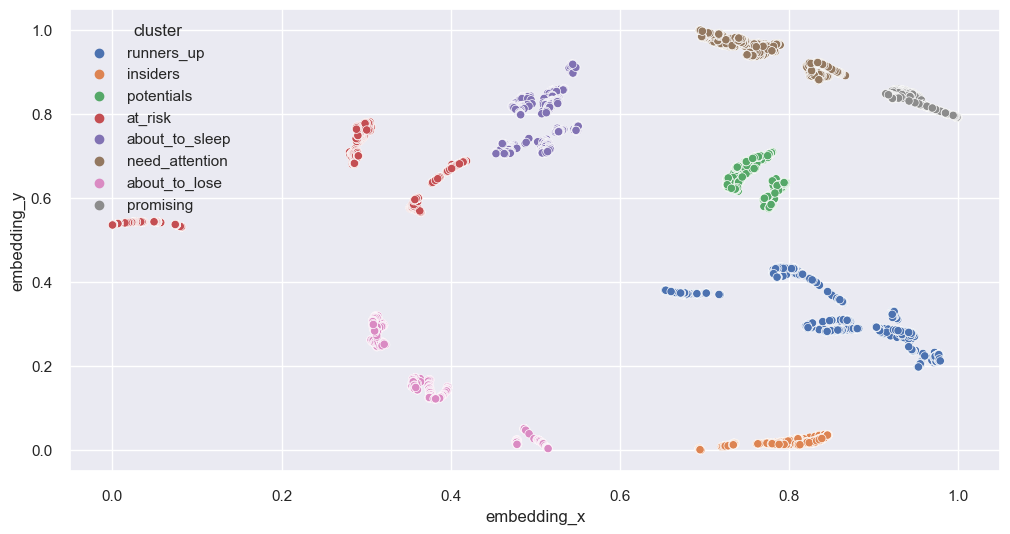

In [82]:
# Renaming the clusters
df10['cluster'] = df10['cluster'].apply(lambda x: 'insiders' if x == 0
                                                            else 'runners_up' if x == 5 
                                                            else 'promising' if x == 6 
                                                            else 'potentials' if x == 1 
                                                            else 'need_attention' if x == 7 
                                                            else 'about_to_sleep' if x == 4 
                                                            else 'at_risk' if x == 3
                                                            else 'about_to_lose')  
# Defining the model
kmeans_model = KMeans(n_clusters=8, random_state=42)

# Training the model
kmeans_model.fit(X)

# Predict
kmeans_labels = kmeans_model.predict(X)

# Metrics
kmeans_sil = silhouette_score(X, kmeans_labels, metric='euclidean')

# Plotting the clusters
sns.scatterplot(x='embedding_x', 
                y='embedding_y', 
                hue='cluster', 
                palette='deep', 
                data=df10)
print(kmeans_sil)                                                 

## 11. **Cluster Exploratory Data Analysis (EDA)**

In [83]:
df11 = df_profile.copy() # Setting df11 as a EDA dataframe

# Renaming the clusters
df11['cluster'] = df11['cluster'].apply(lambda x: 'insiders' if x == 0
                                                            else 'runners_up' if x == 5 
                                                            else 'promising' if x == 6 
                                                            else 'potentials' if x == 1 
                                                            else 'need_attention' if x == 7 
                                                            else 'about_to_sleep' if x == 4 
                                                            else 'at_risk' if x == 3
                                                            else 'about_to_lose')  
df11.head()                                                            

,customer_id,gross_revenue,recency_days,purchases_quantity,qt_items,qt_returns,purchased_returned_diff,cluster
0,17850,5391.21000,372.00000,34.00000,1733.00000,40.00000,7.43426,runners_up
1,13047,3232.59000,56.00000,9.00000,1390.00000,35.00000,7.21156,runners_up
2,12583,6705.38000,2.00000,15.00000,5028.00000,50.00000,8.51278,insiders
3,13748,948.25000,95.00000,5.00000,439.00000,0.00000,6.08450,potentials
4,15100,876.00000,333.00000,3.00000,80.00000,22.00000,4.06044,at_risk


#### 11.1. **Hypotheses Mindmap**

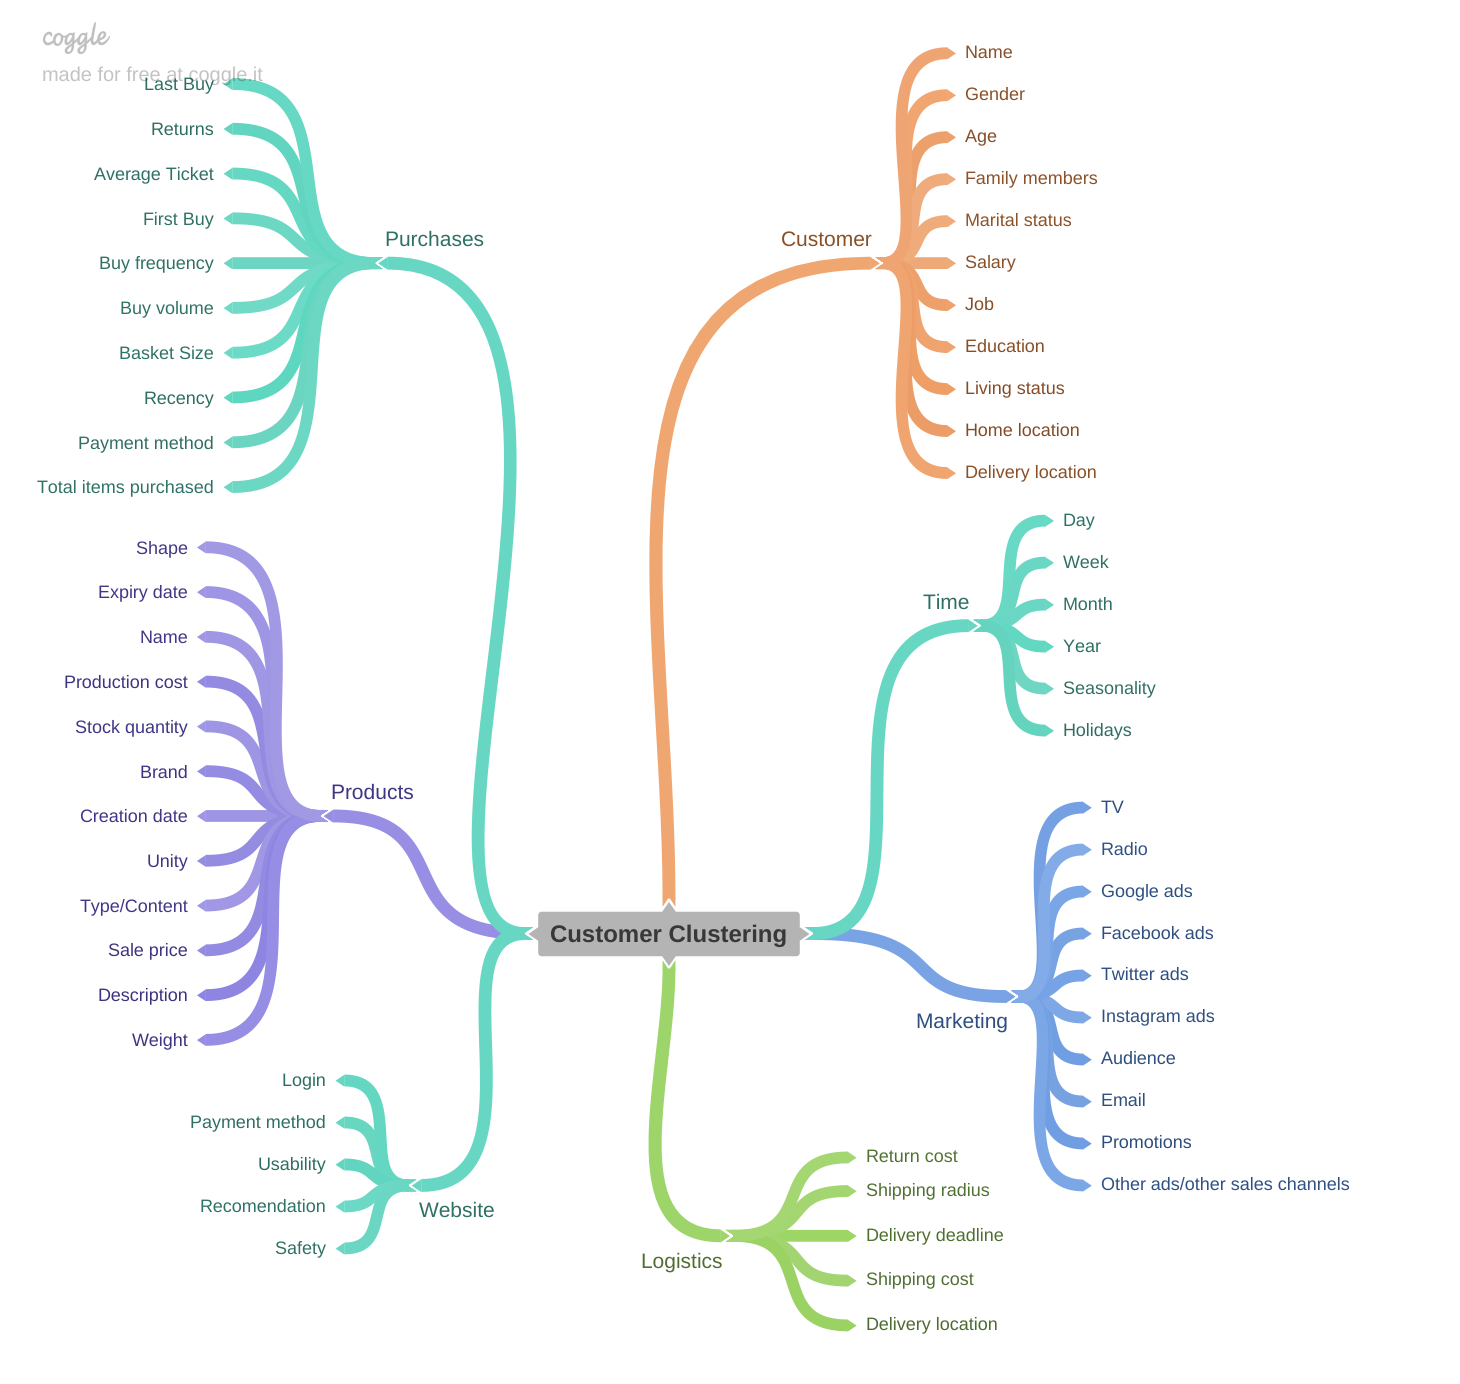

In [84]:
Image('C:/Users/bruno/OneDrive/Documentos/repos/ds-em-clusterizacao/images/clustering_outleto.png', width=1000)

#### 11.2. **Hypotheses Creation**

11.2.1. **Customer Hypotheses**

- **H1:** 60% of customers from Insiders are married.
- **H2:** 20% of customers from Insiders are 24-35 years old.
- **H3:** 40% of delivery locations from Insiders are withing a radius of 50km.
- **H4:** 5% of customers from Insiders make over US$ 100,000 annually. 
- **H5:** 90% of customers from Insiders have a bachelor's degree.

11.2.2. **Purchases Hypotheses**

- **H1:** Customers from Insiders pay with credit card 80% of the times.
- **H2:** Customers from Insiders have an average ticket 10% higher than Runners Up.
- **H3:** Customers from Insiders purchase at least 5 items at time, on average.
- **H4:** Customers from Insiders are responsible for over 30% of the total items purchased.
- **H5:** Customers from Insiders are responsible for over 30% of the total gross revenue.
- **H6:** Customers from Insiders have a number of returns lower than other customers, on average.
- **H7:** The gross revenue median from Insiders is 200% higher than the overall gross revenue median.
- **H8:** Customers from Insiders have their gross revenue concentration on the 3rd quartile. 

11.2.3. **Products Hypotheses**

- **H1:** 30% of all products that come in big packages are bought by customers from Insiders.
- **H2:** The median of product prices bought by Insiders is 10% higher than the median of all products prices.
- **H3:** The average weight of products bought by customers from Insiders is higher than the average weight from other clusters.
- **H4:** The average age of products bought by customers from Insiders is less than 15 days.

#### 11.3. **Final Hypotheses List**

Some hypotheses were removed because there isn't enough data to validate them. The final hypotheses list is available below: 

- ##### **H1: Customers from Insiders are responsible for over 30% of the total items purchased.**
- ##### **H2: Customers from Insiders are responsible for over 30% of the total gross revenue.**
- ##### **H3: Customers from Insiders have a number of returns lower than other customers, on average.**
- ##### **H4: The gross revenue median from Insiders is 200% higher than the overall gross revenue median.**
- ##### **H5: Customers from Insiders have their gross revenue concentration on the 3rd quartile.**

#### 11.4. **Validating Hypotheses**

##### **H1:** Customers from Insiders are responsible for over 30% of the total items purchased.

**TRUE**: Customers from Insiders are responsible for 58.3% of the total items purchased.

<AxesSubplot:xlabel='Clusters', ylabel='Total Quantity of Items'>

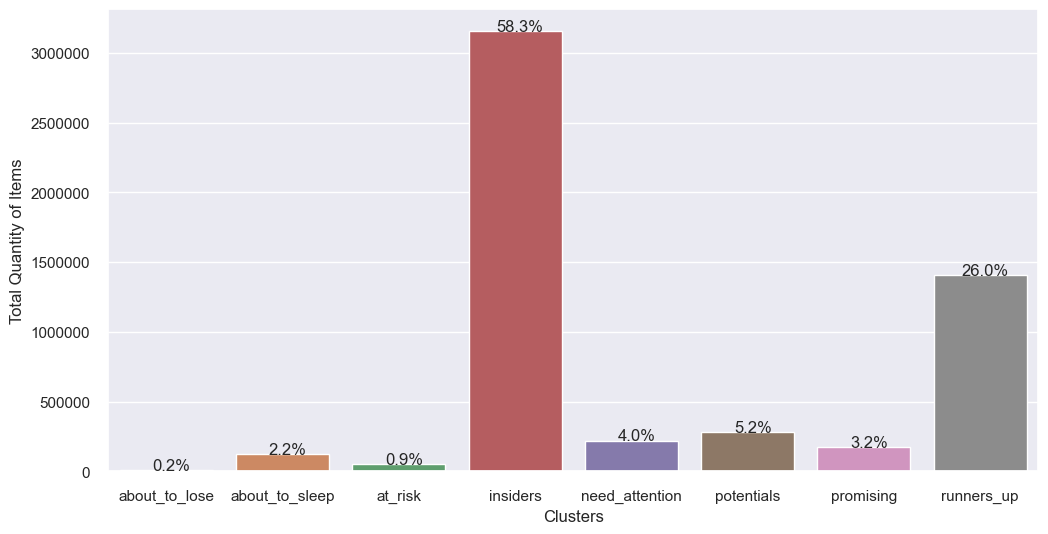

In [85]:
aux = df11[['cluster', 'qt_items']].groupby('cluster').sum().reset_index().rename(columns={'qt_items' : 'total_qt_items_by_cluster'})
bar_plot(aux, 'cluster', 'Clusters', 'total_qt_items_by_cluster', 'Total Quantity of Items')  

##### **H2:** Customers from Insiders are responsible for over 30% of the total gross revenue.

**TRUE**: Customers from Insiders are responsible for 53.5% of the total gross revenue.

<AxesSubplot:xlabel='Clusters', ylabel='Total Gross Revenue (US$)'>

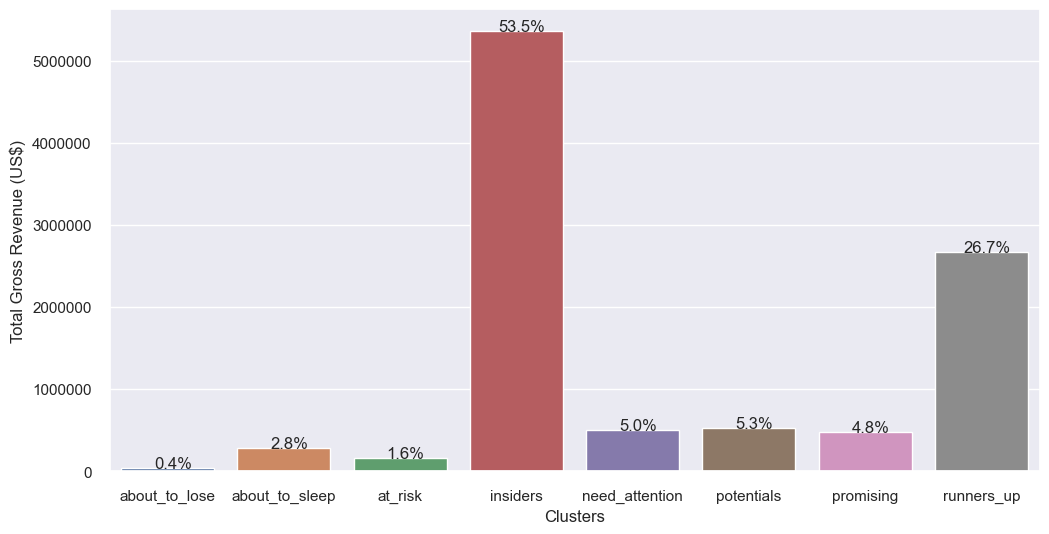

In [86]:
aux = df11[['cluster', 'gross_revenue']].groupby('cluster').sum().reset_index().rename(columns={'gross_revenue' : 'total_gross_revenue_by_cluster'})
bar_plot(aux, 'cluster', 'Clusters', 'total_gross_revenue_by_cluster', 'Total Gross Revenue (US$)')

##### **H3:** Customers from Insiders have a number of returns lower than other customers, on average.

**FALSE**: Customers from Insiders have a number of returns higher than other customers, on average.

<AxesSubplot:xlabel='Clusters', ylabel='Average Returns'>

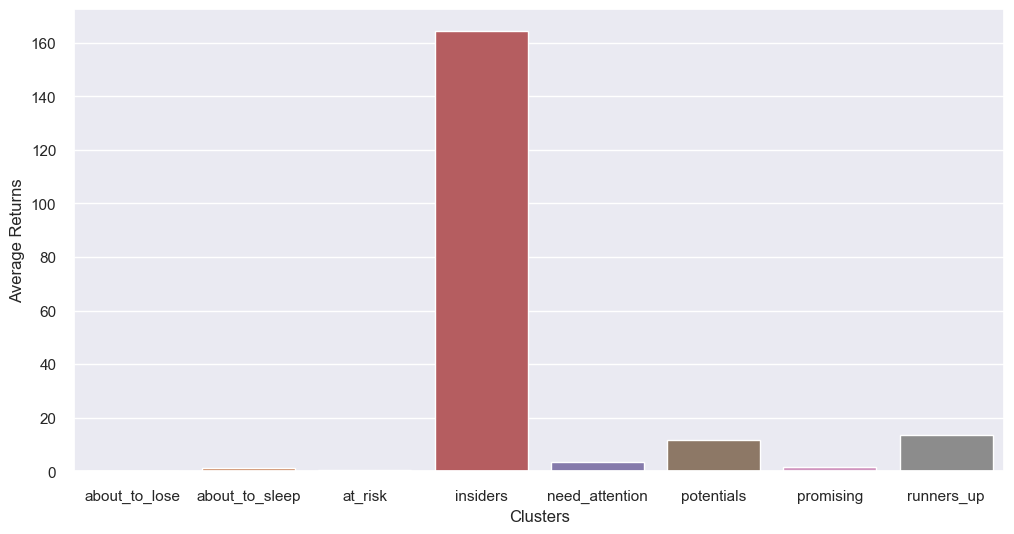

In [87]:
aux = df11[['cluster', 'qt_returns']].groupby('cluster').mean().reset_index().rename(columns={'qt_returns' : 'avg_qt_returns_by_cluster'})
bar_plot(aux, 'cluster', 'Clusters', 'avg_qt_returns_by_cluster', 'Average Returns', pct=False)

##### **H4:** The gross revenue median from Insiders is 200% higher than the overall gross revenue median.

**FALSE**:  The gross revenue median from Insiders is 780.28% higher than the overall gross revenue median.

In [88]:
aux = df11[['cluster', 'gross_revenue']].groupby('cluster').median().reset_index()
aux =  aux[aux['cluster']=='insiders'].values[0][1] # insiders gross revenue median

aux2 = df11['gross_revenue'].median() # overall gross revenue median

print(f'The gross revenue median from Insiders is {((aux - aux2)/aux2)*100:.2f}% higher than the overall gross revenue median.')

The gross revenue median from Insiders is 780.28% higher than the overall gross revenue median.


##### **H5:** Customers from Insiders have their gross revenue concentration on the 3rd quartile. 

**FALSE**:  Customers from Insiders have their gross revenue concentration on the 1st quartile. 

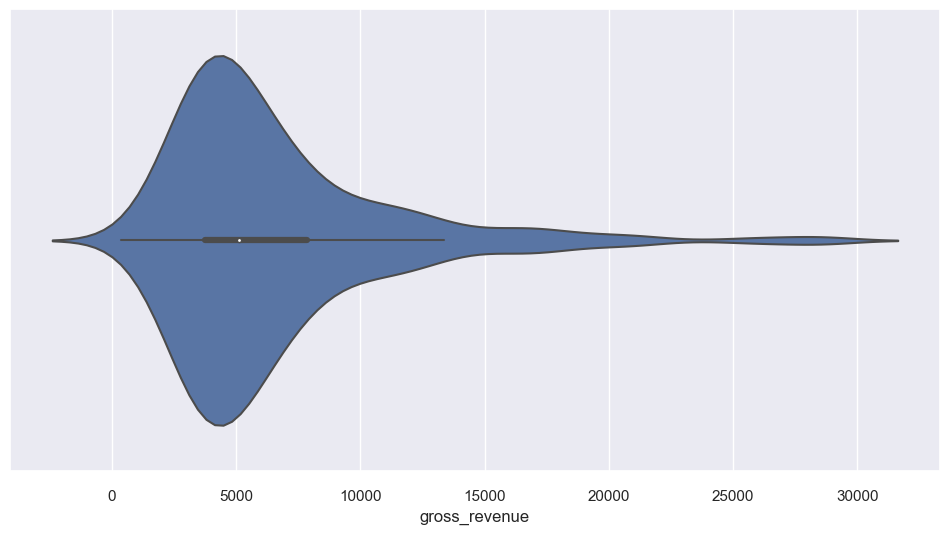

In [89]:
aux = df11.loc[(df11['cluster']=='insiders') & (df11['gross_revenue']< 30000), 'gross_revenue'] # getting 30k minus on gross_revenue, so that the plot can be visualized
sns.violinplot(x=aux);

## 12. **Business Report**

#### **The final list of eligible customers for Insiders will be available inside the project's GitHub repository. Whereas for the business report, it was built using Power BI, where there are answers to the following questions previously demanded by Outleto's Marketing Team.** 

*The full customer list will also be available for download in CSV format inside the project's GitHub repository.*

*The link for the Power BI report is available in the project's README.*

1) **How many customers will be a part of Insiders?**
2) **How many clusters were created?**
3) **How are the customers distributed amongst the clusters?**
4) **What are these customers' main features?**
5) **What's the gross revenue percentage coming from Insiders? And what about other clusters?**
6) **How many items were purchased by each cluster?**

With that report the Marketing Team will promote actions to each cluster, in order to increase revenue, but of course focusing mostly in the Insiders cluster. 

In [90]:
insiders_list = df11.loc[df11['cluster']=='insiders']
# insiders_list.to_csv('insiders_list.csv', index=False) # getting the list

## 13. **Conclusion and Next Steps**

In this project the main objective was accomplished:

<p align="justify"> <b> We managed to provide a business report using Power BI, containing answers to the questions previously demanded by Outleto's Marketing Team, as well as a list of eligible customers to be a part of Insiders. With that report the Marketing Team will promote actions to each cluster, in order to increase revenue, but of course focusing mostly in the Insiders cluster, since they represent 53.5% of the total gross revenue. In addition to that, some useful business insights were found. </b> </p>

<p align="justify"> Further on, this solution could be improved by a few strategies:

- Requesting more data from Outleto, such as product associated data. 

- Creating even more features. 

- Making the final report even more automatic for when new data comes in, so it could be run every time requested and the data instantly saved in the PostgreSQL database. This could be done by using the Papermill library.</p>